In [1]:
# Data Handling & Manipulation
import pandas as pd                                         # for dataframes, CSV/Excel reading, tabular data manipulation
import numpy as np                                          # for numerical operations and array handling

# Data Visualisation (Static)
import matplotlib.pyplot as plt                             # for creating static plots
from matplotlib.ticker import FuncFormatter                 # for customising tick labels (e.g., currency, %)
import seaborn as sns                                       # for statistical visualisation (heatmaps, distplots, etc.)

# Data Visualisation (Interactive)
import plotly.express as px                                 # for quick and interactive visualisation
import plotly.graph_objects as go                           # for custom interactive plots
from plotly.subplots import make_subplots                   # for interactive subplots

# Statistical Testing & Inference
from statsmodels.stats.proportion import proportions_ztest  # for comparing proportions (e.g., late vs. on-time)
from scipy.stats import (
    normaltest,                                             # for checking normality
    chi2_contingency,                                       # for categorical association
    mannwhitneyu,                                           # for non-parametric testing
    ttest_ind,                                              # for independent sample t-test
    f_oneway,                                               # for one-way ANOVA
    kruskal,                                                # for Kruskal-Wallis test
    kstest,                                                 # for Kolmogorov-Smirnov test
    spearmanr                                               # for spearmean correlation
)
import statsmodels.api as sm                                # for advanced statistical modelling and diagnostics
import statsmodels.formula.api as smf                       # for formula-based statistical models
from statsmodels.stats.multicomp import pairwise_tukeyhsd   # for post-hoc tests after ANOVA

# Data Quality & Missing Value Visualisation
import missingno as msno                                    # for visualising missing data patterns

# System & Settings
import os                                                   # for file handling and directory operations
import warnings                                             # to suppress or manage warning messages
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)                 # display full content in cells (useful for text data)

In [2]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
    'master_olist_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
        'shipping_limit_date',
        'review_creation_date',
        'review_answer_timestamp',
    ]
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load master dataset

In [3]:
master_olist_dataset = read_olist_csv('../data/cleaned_data/master_olist_dataset.csv')

In [4]:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109933 non-null  object        
 1   customer_id                    109933 non-null  object        
 2   order_status                   109933 non-null  object        
 3   order_purchase_timestamp       109933 non-null  datetime64[ns]
 4   order_approved_at              109933 non-null  datetime64[ns]
 5   order_delivered_carrier_date   109933 non-null  datetime64[ns]
 6   order_delivered_customer_date  109933 non-null  datetime64[ns]
 7   order_estimated_delivery_date  109933 non-null  datetime64[ns]
 8   customer_unique_id             109933 non-null  object        
 9   customer_zip_code_prefix       109933 non-null  int64         
 10  customer_city                  109933 non-null  object        
 11  

In [5]:
master_olist_ml_df = master_olist_dataset.copy()

## Create Target Variable (is_late)

In [6]:
master_olist_ml_df['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']

## Drop unused features

In [7]:
master_olist_ml_df['dispatch_delay'] = (master_olist_ml_df['order_delivered_carrier_date'] - master_olist_ml_df['shipping_limit_date']).dt.days
master_olist_ml_df['is_late_dispatch'] = (master_olist_ml_df['dispatch_delay'] > 0)

In [8]:
features_after_approval = [
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'dispatch_delay',
    'review_id',
    'review_score',
    'review_comment_title',
    'review_comment_message',
    'review_creation_date',
    'review_answer_timestamp',
    'has_review',
]

In [9]:
master_olist_ml_df = master_olist_ml_df.drop(columns=features_after_approval)

master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109933 non-null  object        
 1   customer_id                    109933 non-null  object        
 2   order_status                   109933 non-null  object        
 3   order_purchase_timestamp       109933 non-null  datetime64[ns]
 4   order_approved_at              109933 non-null  datetime64[ns]
 5   order_estimated_delivery_date  109933 non-null  datetime64[ns]
 6   customer_unique_id             109933 non-null  object        
 7   customer_zip_code_prefix       109933 non-null  int64         
 8   customer_city                  109933 non-null  object        
 9   customer_state                 109933 non-null  object        
 10  order_item_id                  109933 non-null  float64       
 11  

# Features Creation

## Geographical Features

In [10]:
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

### Add aggregated lat & lng pair for both customers & sellers

In [11]:
# Merge location data
# Get median geo coordinates for each zip code
median_coords = cleaned_df_geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'median',
    'geolocation_lng': 'median'
}).reset_index()

# Merge customer geo data
master_olist_ml_df = master_olist_ml_df.merge(
    median_coords,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
})

# Merge seller geo data 
master_olist_ml_df = master_olist_ml_df.merge(
    median_coords,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left',
    suffixes=('_drop', '')
).rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
})

# Drop redundant columns
master_olist_ml_df = master_olist_ml_df.drop(columns=['geolocation_zip_code_prefix', 'geolocation_zip_code_prefix_drop'], errors='ignore')
master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109933 non-null  object        
 1   customer_id                    109933 non-null  object        
 2   order_status                   109933 non-null  object        
 3   order_purchase_timestamp       109933 non-null  datetime64[ns]
 4   order_approved_at              109933 non-null  datetime64[ns]
 5   order_estimated_delivery_date  109933 non-null  datetime64[ns]
 6   customer_unique_id             109933 non-null  object        
 7   customer_zip_code_prefix       109933 non-null  int64         
 8   customer_city                  109933 non-null  object        
 9   customer_state                 109933 non-null  object        
 10  order_item_id                  109933 non-null  float64       
 11  

#### Handle missing lat/lng

The missing lat & lng are due to customer/seller having a zip_code_prefix that doesn't exists in the geolocation dataset

In [12]:
# Check missing percentage for customer and seller coordinates
missing_coords = {
    'customer_lat': (master_olist_ml_df['customer_lat'].isna().sum() / len(master_olist_ml_df)) * 100,
    'customer_lng': (master_olist_ml_df['customer_lng'].isna().sum() / len(master_olist_ml_df)) * 100,
    'seller_lat': (master_olist_ml_df['seller_lat'].isna().sum() / len(master_olist_ml_df)) * 100,
    'seller_lng': (master_olist_ml_df['seller_lng'].isna().sum() / len(master_olist_ml_df)) * 100
}

# Create a DataFrame to display the missing percentages
missing_coords_df = pd.DataFrame({
    'Column': list(missing_coords.keys()),
    'Missing %': list(missing_coords.values())
})

# Calculate the number of rows with any missing coordinate
rows_with_missing = master_olist_ml_df[
    master_olist_ml_df['customer_lat'].isna() | 
    master_olist_ml_df['customer_lng'].isna() | 
    master_olist_ml_df['seller_lat'].isna() | 
    master_olist_ml_df['seller_lng'].isna()
].shape[0]

# Calculate percentage of rows with any missing coordinate
pct_rows_with_missing = (rows_with_missing / len(master_olist_ml_df)) * 100

# Display results
print(missing_coords_df)
print(f"\nRows with any missing coordinate: {rows_with_missing} ({pct_rows_with_missing:.2f}%)")

         Column  Missing %
0  customer_lat   0.262887
1  customer_lng   0.262887
2    seller_lat   0.226502
3    seller_lng   0.226502

Rows with any missing coordinate: 537 (0.49%)


In [13]:
# overall share of orders by state
overall_customer = (master_olist_ml_df['customer_state']
           .value_counts(normalize=True)
           .rename('overall_customer_prop'))

overall_seller = (master_olist_ml_df['seller_state']
          .value_counts(normalize=True)
          .rename('overall_seller_prop'))

# Create masks for missing coordinates
missing_customer_mask = master_olist_ml_df['customer_lat'].isna()
missing_seller_mask = master_olist_ml_df['seller_lat'].isna()

# Calculate proportion for missing customer coordinates by state
missing_customer_prop = (master_olist_ml_df.loc[missing_customer_mask, 'customer_state']
                .value_counts(normalize=True)
                .rename('missing_customer_prop'))

# Calculate proportion for missing seller coordinates by state
missing_seller_prop = (master_olist_ml_df.loc[missing_seller_mask, 'seller_state']
                .value_counts(normalize=True)
                .rename('missing_seller_prop'))

# Create a dataframe for customer bias analysis
customer_bias = (pd.concat([overall_customer, missing_customer_prop], axis=1)
                .fillna(0)
                .assign(customer_lift=lambda d: d['missing_customer_prop'] / d['overall_customer_prop']))

# Create a dataframe for seller bias analysis
seller_bias = (pd.concat([overall_seller, missing_seller_prop], axis=1)
                .fillna(0)
                .assign(seller_lift=lambda d: d['missing_seller_prop'] / d['overall_seller_prop']))

# Show the top 10 states with highest lift for customers
display(customer_bias.sort_values('customer_lift', ascending=False))

display(seller_bias.sort_values('seller_lift', ascending=False))

,overall_customer_prop,missing_customer_prop,customer_lift
customer_state,,,
DF,0.021386,0.619377,28.962139
RO,0.002483,0.006920,2.786747
PI,0.004721,0.010381,2.198792
CE,0.012962,0.020761,1.601646
GO,0.020658,0.031142,1.507494
RN,0.004739,0.006920,1.460234
MA,0.007250,0.010381,1.431836
PB,0.005331,0.006920,1.298263
BA,0.033466,0.041522,1.240743


,overall_seller_prop,missing_seller_prop,seller_lift
seller_state,,,
DF,0.008023,0.164659,20.523149
MG,0.078002,0.244980,3.140685
SP,0.713307,0.558233,0.782598
RS,0.019685,0.008032,0.408039
PR,0.077038,0.024096,0.312786
CE,0.000819,0.000000,0.000000
PA,0.000073,0.000000,0.000000
SE,0.000091,0.000000,0.000000
PI,0.000100,0.000000,0.000000


Only 0.5 % of orders lacked ZIP-level coordinates. Because 62 % of these came from Brasília (a compact metro area), we imputed missing lat/lng with the median of all geolocation points in the same state and flagged those rows. This retains all data while avoiding external APIs and introducing no target leakage.

- Only 0.26 % of customers and 0.23 % of sellers lack coordinates.
- \> 60 % of those gaps are in DF (Brasília)—a single, geographically small metro area.
- Remaining gaps are scattered, each contributing ≪ 0.05 % of total rows.	
- A single median point for DF is basically a city centroid (< 15 km error)—more precise than the entire state centroid would be in SP or MG.
- Errors elsewhere (SP, MG, etc.) affect < 0.1 % of rows, so any blurring is statistically negligible.

In [14]:
# build once
state_centroids = (cleaned_df_geolocation
                   .groupby('geolocation_state', as_index=False)
                   .agg(state_lat=('geolocation_lat', 'median'),
                        state_lng=('geolocation_lng', 'median')))

def impute_state_centroid(df, role):
    df = df.merge(state_centroids,
                  left_on=f'{role}_state',
                  right_on='geolocation_state',
                  how='left')
    mask = df[f'{role}_lat'].isna()
    df.loc[mask, f'{role}_lat'] = df.loc[mask, 'state_lat']
    df.loc[mask, f'{role}_lng'] = df.loc[mask, 'state_lng']
    df[f'{role}_coord_imputed'] = mask          # flag uncertainty
    return df.drop(columns=['state_lat', 'state_lng', 'geolocation_state'])

master_olist_ml_df = impute_state_centroid(master_olist_ml_df, 'customer')
master_olist_ml_df = impute_state_centroid(master_olist_ml_df, 'seller')

master_olist_ml_df = master_olist_ml_df.drop(columns=['customer_coord_imputed', 'seller_coord_imputed'], errors='ignore')

master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109933 non-null  object        
 1   customer_id                    109933 non-null  object        
 2   order_status                   109933 non-null  object        
 3   order_purchase_timestamp       109933 non-null  datetime64[ns]
 4   order_approved_at              109933 non-null  datetime64[ns]
 5   order_estimated_delivery_date  109933 non-null  datetime64[ns]
 6   customer_unique_id             109933 non-null  object        
 7   customer_zip_code_prefix       109933 non-null  int64         
 8   customer_city                  109933 non-null  object        
 9   customer_state                 109933 non-null  object        
 10  order_item_id                  109933 non-null  float64       
 11  

### Add customer-seller distance using Haversine Distance (kilometers)

In [15]:
# Calculate distance between customer and seller
# Using Haversine formula to calculate distance between two coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Apply the formula to calculate distance for all rows with valid coordinates
mask = (~master_olist_ml_df['customer_lat'].isna()) & (~master_olist_ml_df['seller_lat'].isna())
master_olist_ml_df.loc[mask, 'distance_km'] = haversine(
    master_olist_ml_df.loc[mask, 'customer_lat'],
    master_olist_ml_df.loc[mask, 'customer_lng'],
    master_olist_ml_df.loc[mask, 'seller_lat'],
    master_olist_ml_df.loc[mask, 'seller_lng']
)

In [16]:

# Print summary statistics of the new distance feature
print(f"Distance statistics (km):")
print(f"Mean: {master_olist_ml_df['distance_km'].mean():.2f}")
print(f"Median: {master_olist_ml_df['distance_km'].median():.2f}")
print(f"Min: {master_olist_ml_df['distance_km'].min():.2f}")
print(f"Max: {master_olist_ml_df['distance_km'].max():.2f}")
print(f"Null values: {master_olist_ml_df['distance_km'].isna().sum()}")

Distance statistics (km):
Mean: 596.77
Median: 433.35
Min: 0.00
Max: 3398.55
Null values: 0


In [17]:
late_dist  = master_olist_ml_df.loc[master_olist_ml_df['is_late'],  'distance_km']
ontime_dist = master_olist_ml_df.loc[~master_olist_ml_df['is_late'], 'distance_km']

Shapiro late:    3.0244495806854816e-56
Shapiro on-time: 1.5017355380503234e-59
Levene’s p-value: 9.738653701968938e-78


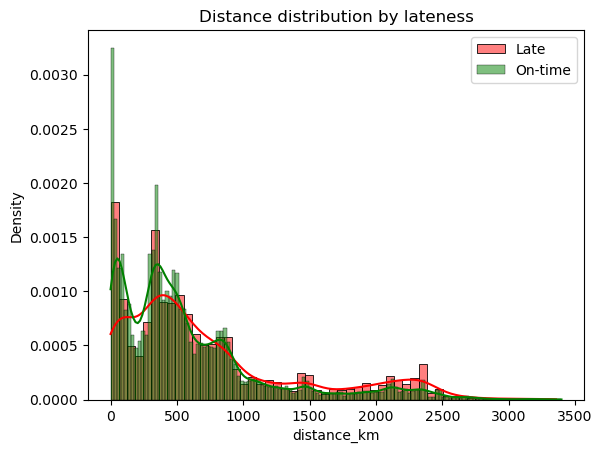

In [18]:
from scipy import stats

# Histogram
sns.histplot(late_dist,   color='r', label='Late',   stat='density', kde=True)
sns.histplot(ontime_dist, color='g', label='On-time', stat='density', kde=True)
plt.legend(); plt.title("Distance distribution by lateness")

# Normality
print("Shapiro late:   ", stats.shapiro(late_dist.sample(5000))[1])
print("Shapiro on-time:", stats.shapiro(ontime_dist.sample(5000))[1])

# Variance test
print("Levene’s p-value:", stats.levene(late_dist, ontime_dist).pvalue)

In [19]:
u_stat, p_val = stats.mannwhitneyu(late_dist, ontime_dist, alternative='two-sided')
print(f"Mann–Whitney U = {u_stat:.0f}, p-value = {p_val:.3g}")

r_pb = stats.pointbiserialr(master_olist_ml_df['is_late'], master_olist_ml_df['distance_km'])
print(f"Point-biserial r = {r_pb.correlation:.3f}, p-value = {r_pb.pvalue:.3g}")

Mann–Whitney U = 495120099, p-value = 1.2e-81
Point-biserial r = 0.068, p-value = 1.01e-113


### Same-state vs Inter-state delivery

In [20]:
# same_state
master_olist_ml_df["same_state"] = (master_olist_ml_df["customer_state"] == master_olist_ml_df["seller_state"]).astype(int)

In [21]:
master_olist_ml_df[['customer_state', 'seller_state', 'same_state']].head(10)

,customer_state,seller_state,same_state
0,SP,SP,1
1,BA,SP,0
2,GO,SP,0
3,RN,MG,0
4,SP,SP,1
5,PR,SP,0
6,RJ,SP,0
7,RS,SP,0
8,SP,SP,1
9,RJ,ES,0


#### Quick analysis of the feature

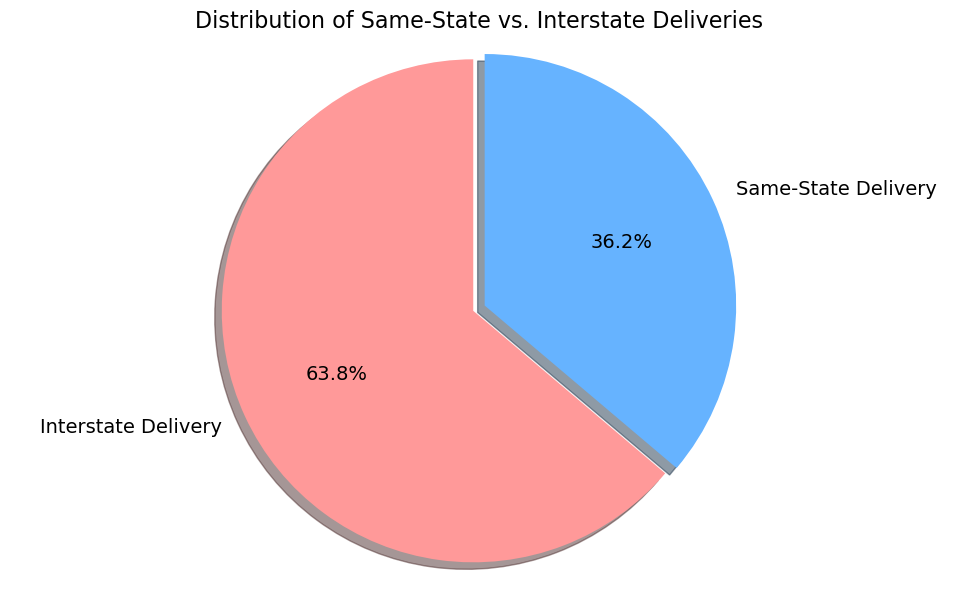

Interstate deliveries: 70157 (63.8%)
Same-state deliveries: 39776 (36.2%)


In [22]:
# Create a pie chart for same_state distribution
plt.figure(figsize=(10, 6))
labels = ['Interstate Delivery', 'Same-State Delivery']
sizes = master_olist_ml_df['same_state'].value_counts().sort_index()
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)  # explode the 1st slice for emphasis

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=90, textprops={'fontsize': 14})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.title('Distribution of Same-State vs. Interstate Deliveries', fontsize=16)
plt.tight_layout()
plt.show()

# Add a text summary
interstate_pct = sizes[0] / sizes.sum() * 100
same_state_pct = sizes[1] / sizes.sum() * 100
print(f"Interstate deliveries: {sizes[0]} ({interstate_pct:.1f}%)")
print(f"Same-state deliveries: {sizes[1]} ({same_state_pct:.1f}%)")

**Is being an interstate shipment (seller ≠ customer state) associated with a different late-delivery rate than shipments that stay inside the same state?**

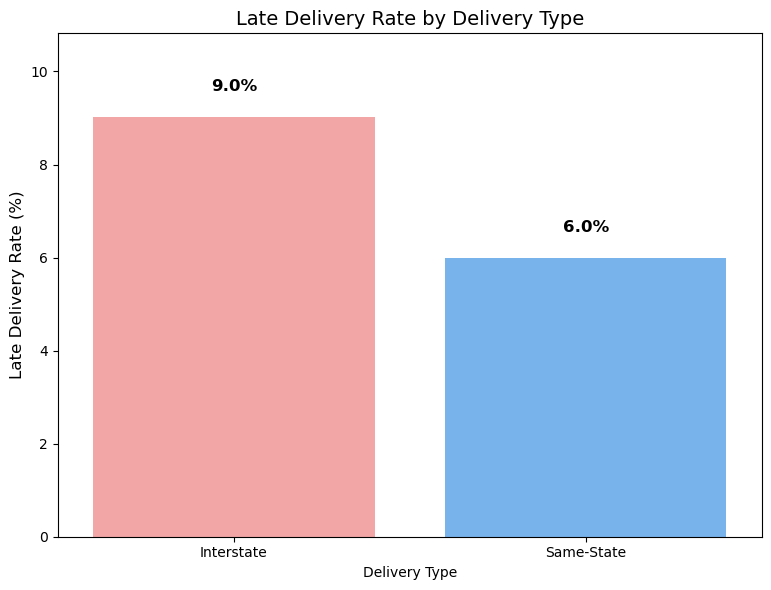

Chi-square statistic: 318.76
p-value: 0.0000000000
Degrees of freedom: 1

Conclusion: There is a statistically significant relationship between delivery type and late delivery rate (p < 0.05).
Effect size (Cramer's V): 0.0538 (negligible association)
Odds ratio: 1.56
Interstate deliveries are 1.56x more likely to be late than same-state deliveries.


In [23]:
# 1. Create a contingency table for statistical analysis
contingency = pd.crosstab(master_olist_ml_df['same_state'], master_olist_ml_df['is_late'])

# 2. Calculate late rates by delivery type
late_rates = pd.DataFrame({
    'Delivery Type': ['Interstate', 'Same-State'],
    'Count': [contingency.loc[0].sum(), contingency.loc[1].sum()],
    'Late Count': [contingency.loc[0, True], contingency.loc[1, True]],
})
late_rates['Late Rate'] = late_rates['Late Count'] / late_rates['Count'] * 100
late_rates['On-time Count'] = late_rates['Count'] - late_rates['Late Count']

# 3. Run a chi-square test to check for statistical significance
chi2, p_value, dof, expected = chi2_contingency(contingency)

# 4. Create visualizations to illustrate the relationship
plt.figure(figsize=(15, 6))

# 4.1 Side-by-side bar chart comparing late rates
plt.subplot(1, 2, 1)
sns.barplot(x='Delivery Type', y='Late Rate', data=late_rates, palette=['#ff9999', '#66b3ff'])
plt.title('Late Delivery Rate by Delivery Type', fontsize=14)
plt.ylabel('Late Delivery Rate (%)', fontsize=12)
plt.ylim(0, max(late_rates['Late Rate']) * 1.2)  # Add some headroom

# Add actual percentages as text labels
for i, row in late_rates.iterrows():
    plt.text(i, row['Late Rate'] + 0.5, f"{row['Late Rate']:.1f}%", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Print statistical analysis summary
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.10f}")
print(f"Degrees of freedom: {dof}")

# Helper function for interpreting Cramer's V
def interpret_cramers_v(v):
    if v < 0.1:
        return "negligible association"
    elif v < 0.2:
        return "weak association"
    elif v < 0.3:
        return "moderate association"
    elif v < 0.4:
        return "relatively strong association"
    else:
        return "strong association"

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: There is a statistically significant relationship between delivery type and late delivery rate (p < {alpha}).")
    
    # Calculate the strength of the relationship (Cramer's V)
    n = contingency.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
    print(f"Effect size (Cramer's V): {cramer_v:.4f} ({interpret_cramers_v(cramer_v)})")
    
    # Calculate odds ratio for interpretability
    odds_ratio = (contingency.loc[0, True] / contingency.loc[0, False]) / (contingency.loc[1, True] / contingency.loc[1, False])
    print(f"Odds ratio: {odds_ratio:.2f}")
    print(f"Interstate deliveries are {odds_ratio:.2f}x more likely to be late than same-state deliveries.")
else:
    print(f"\nConclusion: There is NO statistically significant relationship between delivery type and late delivery rate (p > {alpha}).")

**Interpretation**

| Metric                       | Value                      | Rule-of-thumb interpretation                                        |
| ---------------------------- | -------------------------- | ------------------------------------------------------------------- |
| **Absolute risk difference** | 9.0 % − 6.0 % = **3.0 pp** | 3 extra late orders per 100 when the shipment crosses a state line. |
| **Odds ratio**               | **1.56**                   | The *odds* of being late rise 56 % for interstate vs. same-state.   |
| **Cramér’s V**               | **0.0538**                 | “Negligible” by textbook cut-offs (< 0.10).                         |

Why the contrast?
Because there are 100k+ orders. With that much data, even a small percentage-point gap drives a huge χ² statistic. Cramér's V scales the χ² by sample size, so it flags that the association, while real, is not especially strong relative to all the variation in lateness.

Interstate shipments have a 9.0 % late rate vs. 6.0 % for same-state (χ² = 318, p < 10⁻¹⁰).
The odds of a late arrival rise 56 % when a parcel crosses a state line, but the overall effect size is small (Cramér’s V = 0.05). Distance and other logistics factors likely drive most of the lateness variance, so we will include same_state as a supporting feature rather than a primary focus.

### Is Customer on a Remote Location?

Customers in remote locations face higher risks of late delivery and higher shipping costs.

A customer is marked as remote if their delivery distance (`distance_km`) is above the 75th percentile for all orders, or if their shipping cost relative to product price (`freight_ratio`) is above the 95th percentile. This approach captures both customers who are physically far and those who are expensive to serve, even if they aren’t the farthest.

`freight_ratio` is calculated as `freight_value / price`. This metric shows how large the shipping cost is compared to the order value, highlighting customers who pay a disproportionately high shipping fee for their purchase. High `freight_ratio` values often signal remote regions, limited carrier options, or special logistics challenges that aren’t explained by distance alone. Using both distance and freight ratio together allows the model to detect a broader range of "remote" customers, covering both physical and economic remoteness.

In [24]:
# Create freight_ratio first
master_olist_ml_df["freight_ratio"] = master_olist_ml_df["freight_value"] / master_olist_ml_df["price"].clip(lower=1)

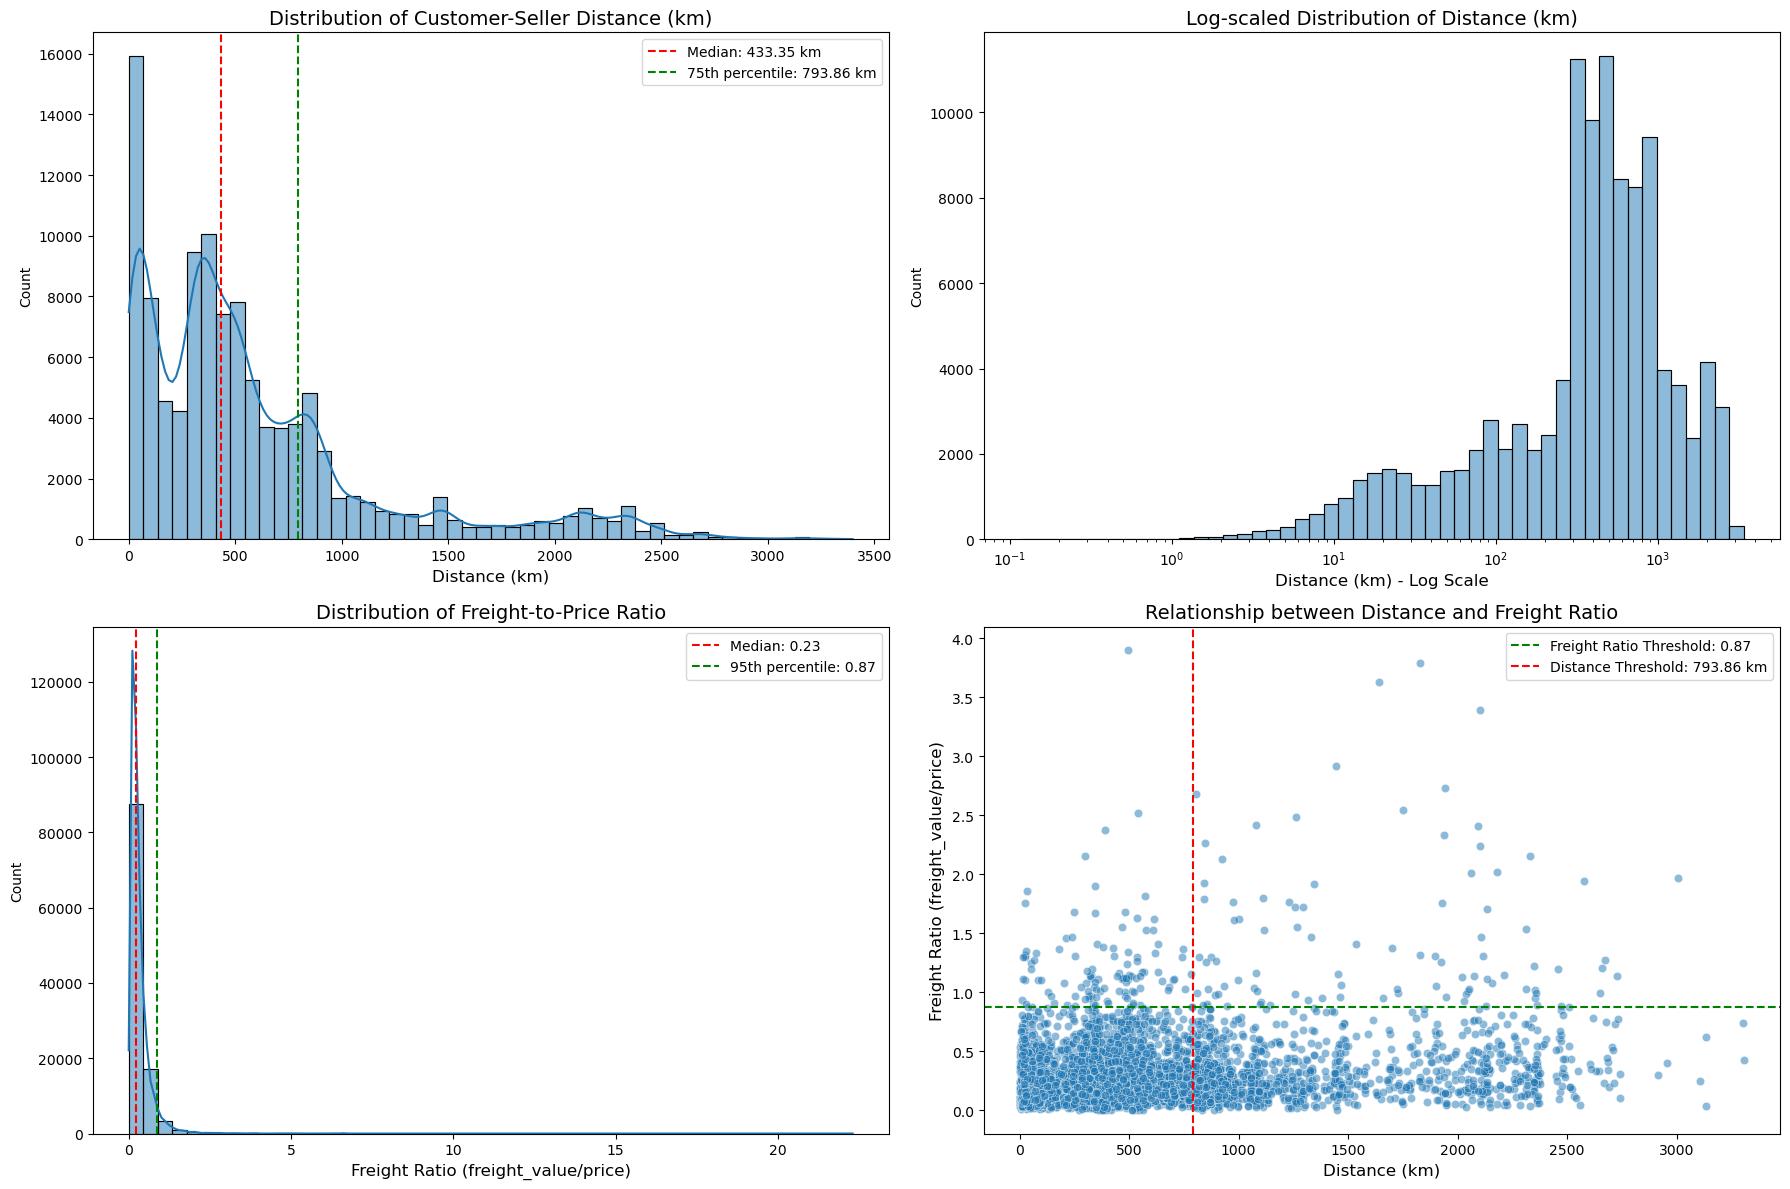


Summary Statistics for Distance (km):
Mean: 596.77
Median: 433.35
25th percentile: 185.95
75th percentile: 793.86
95th percentile: 2085.99
Max: 3398.55

Summary Statistics for Freight Ratio:
Mean: 0.32
Median: 0.23
75th percentile: 0.39
95th percentile: 0.87
Max: 22.30


In [25]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Distribution of distance_km
sns.histplot(master_olist_ml_df['distance_km'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Customer-Seller Distance (km)', fontsize=14)
axes[0, 0].set_xlabel('Distance (km)', fontsize=12)
axes[0, 0].axvline(master_olist_ml_df['distance_km'].median(), color='red', linestyle='--', label=f'Median: {master_olist_ml_df["distance_km"].median():.2f} km')
axes[0, 0].axvline(master_olist_ml_df['distance_km'].quantile(0.75), color='green', linestyle='--', label=f'75th percentile: {master_olist_ml_df["distance_km"].quantile(0.75):.2f} km')
axes[0, 0].legend()

# Plot 2: Log-scaled distribution of distance_km to better see the pattern
sns.histplot(master_olist_ml_df['distance_km'], bins=50, kde=True, log_scale=True, ax=axes[0, 1])
axes[0, 1].set_title('Log-scaled Distribution of Distance (km)', fontsize=14)
axes[0, 1].set_xlabel('Distance (km) - Log Scale', fontsize=12)

# Plot 3: Distribution of freight_ratio
sns.histplot(master_olist_ml_df['freight_ratio'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Freight-to-Price Ratio', fontsize=14)
axes[1, 0].set_xlabel('Freight Ratio (freight_value/price)', fontsize=12)
axes[1, 0].axvline(master_olist_ml_df['freight_ratio'].median(), color='red', linestyle='--', label=f'Median: {master_olist_ml_df["freight_ratio"].median():.2f}')
axes[1, 0].axvline(master_olist_ml_df['freight_ratio'].quantile(0.95), color='green', linestyle='--', label=f'95th percentile: {master_olist_ml_df["freight_ratio"].quantile(0.95):.2f}')
axes[1, 0].legend()

# Plot 4: Scatter plot of distance_km vs freight_ratio
sns.scatterplot(
    data=master_olist_ml_df.sample(5000),  # Sample for better visualization
    x='distance_km',
    y='freight_ratio',
    alpha=0.5,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Relationship between Distance and Freight Ratio', fontsize=14)
axes[1, 1].set_xlabel('Distance (km)', fontsize=12)
axes[1, 1].set_ylabel('Freight Ratio (freight_value/price)', fontsize=12)

# Thresholds for remote customer definition
remote_dist_thr = master_olist_ml_df["distance_km"].quantile(0.75)
remote_freight_thr = master_olist_ml_df["freight_ratio"].quantile(0.95)
axes[1, 1].axhline(remote_freight_thr, color='green', linestyle='--', label=f'Freight Ratio Threshold: {remote_freight_thr:.2f}')
axes[1, 1].axvline(remote_dist_thr, color='red', linestyle='--', label=f'Distance Threshold: {remote_dist_thr:.2f} km')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Distance (km):")
print(f"Mean: {master_olist_ml_df['distance_km'].mean():.2f}")
print(f"Median: {master_olist_ml_df['distance_km'].median():.2f}")
print(f"25th percentile: {master_olist_ml_df['distance_km'].quantile(0.25):.2f}")
print(f"75th percentile: {master_olist_ml_df['distance_km'].quantile(0.75):.2f}")
print(f"95th percentile: {master_olist_ml_df['distance_km'].quantile(0.95):.2f}")
print(f"Max: {master_olist_ml_df['distance_km'].max():.2f}")

print("\nSummary Statistics for Freight Ratio:")
print(f"Mean: {master_olist_ml_df['freight_ratio'].mean():.2f}")
print(f"Median: {master_olist_ml_df['freight_ratio'].median():.2f}")
print(f"75th percentile: {master_olist_ml_df['freight_ratio'].quantile(0.75):.2f}")
print(f"95th percentile: {master_olist_ml_df['freight_ratio'].quantile(0.95):.2f}")
print(f"Max: {master_olist_ml_df['freight_ratio'].max():.2f}")

The 75th percentile for distance is used to flag customers in the longest 25% of delivery routes, capturing those who are physically far from sellers without excluding too much data. For freight ratio, the 95th percentile is chosen because its distribution is highly skewed; this threshold isolates the rare but significant cases where shipping costs are disproportionately high compared to product price. Visualizing these distributions confirms that these cutoffs effectively separate typical orders from those facing true remoteness or economic delivery barriers.

In [26]:
# 75th percentile distance, 95th percentile freight ratio
remote_dist_thr = master_olist_ml_df["distance_km"].quantile(0.75)
remote_freight_thr = master_olist_ml_df["freight_ratio"].quantile(0.95)

# Flag customers in remote locations
master_olist_ml_df["customer_is_remote"] = (
    (master_olist_ml_df["distance_km"] > remote_dist_thr) | 
    (master_olist_ml_df["freight_ratio"] > remote_freight_thr)
).astype(int)

# Display distribution of remote flags
print(f"Remote customer locations: {master_olist_ml_df['customer_is_remote'].sum()} ({master_olist_ml_df['customer_is_remote'].mean()*100:.2f}%)")
print(f"Distance threshold: {remote_dist_thr:.2f} km")
print(f"Freight ratio threshold: {remote_freight_thr:.4f}")

Remote customer locations: 30571 (27.81%)
Distance threshold: 793.86 km
Freight ratio threshold: 0.8729


In [27]:
# Aggregate to order-level (one row per order)
order_level = (
    master_olist_ml_df
    .groupby('order_id')
    .agg(
        customer_is_remote=('customer_is_remote', 'max'),  # if any item is remote, the order is remote
        is_late=('is_late', 'max'),                        
    )
    .reset_index()
)

# Run late-rate comparison
late_rate_tbl = (
    order_level
    .groupby('customer_is_remote')['is_late']
    .agg(['count', 'sum'])
    .assign(late_rate_pct = lambda d: d['sum'] / d['count'] * 100)
    .rename({0: 'Not remote', 1: 'Remote'}, axis=0)
)

print(late_rate_tbl[['late_rate_pct']])

# Chi-square test
contingency = pd.crosstab(order_level['customer_is_remote'], order_level['is_late'])
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(contingency)

print(f"\nChi-square = {chi2:.2f},  p-value = {p:.3e}")

if p < 0.05:
    print("⭑ Statistically significant difference in late-rates.")
else:
    print("No significant difference detected.")

                    late_rate_pct
customer_is_remote               
Not remote               7.330740
Remote                  10.180288

Chi-square = 210.19,  p-value = 1.248e-47
⭑ Statistically significant difference in late-rates.


### Seller's frequency to send orders interstate

`seller_dispatch_hub` represents how often a seller ships orders to a different state than their own.  
For each seller, we calculate the proportion of orders delivered out-of-state, using Laplace smoothing:

hub_score = (number of orders shipped out-of-state + 2) / (total orders + 4)

Laplace smoothing (+2 in the numerator and +4 in the denominator) avoids extreme 0% or 100% values for sellers with very few orders.

This feature is useful because:
- It captures whether a seller acts like a regional/national "hub" (shipping all over Brazil) or mainly serves local customers.
- Sellers with high hub scores typically have more complex logistics, face longer delivery routes, and may have different late delivery risks than purely local sellers.
- It provides a seller-level characteristic that stays stable across orders, giving the model more context about the seller's operational style.
- Used alongside distance, it helps the model distinguish between orders shipped far by experienced "hub" sellers and those shipped by local-only sellers.

In short, `seller_dispatch_hub` helps the model account for differences in seller reach, logistics complexity, and delivery risk.

In [28]:
# seller_dispatch_hub (seller’s % of orders going out-of-state)
seller_home_state = master_olist_ml_df.groupby("seller_id")["seller_state"].first()
master_olist_ml_df = master_olist_ml_df.merge(seller_home_state.rename("seller_home_state"), on="seller_id", how="left")
master_olist_ml_df["is_outside_home"] = (master_olist_ml_df["customer_state"] != master_olist_ml_df["seller_home_state"]).astype(int)

seller_hub_score = (
    master_olist_ml_df.groupby("seller_id")["is_outside_home"]
    .agg(["sum", "count"])
    .assign(hub_score=lambda x: (x["sum"] + 2) / (x["count"] + 4))  # Laplace smoothing
)["hub_score"]

master_olist_ml_df["seller_dispatch_hub"] = master_olist_ml_df["seller_id"].map(seller_hub_score)

In [29]:
master_olist_ml_df['seller_dispatch_hub'].sort_values(ascending=False)

21905     0.966387
35604     0.966387
87547     0.966387
3692      0.966387
103347    0.966387
            ...   
56071     0.074074
36677     0.074074
86413     0.074074
11833     0.074074
11832     0.074074
Name: seller_dispatch_hub, Length: 109933, dtype: float64

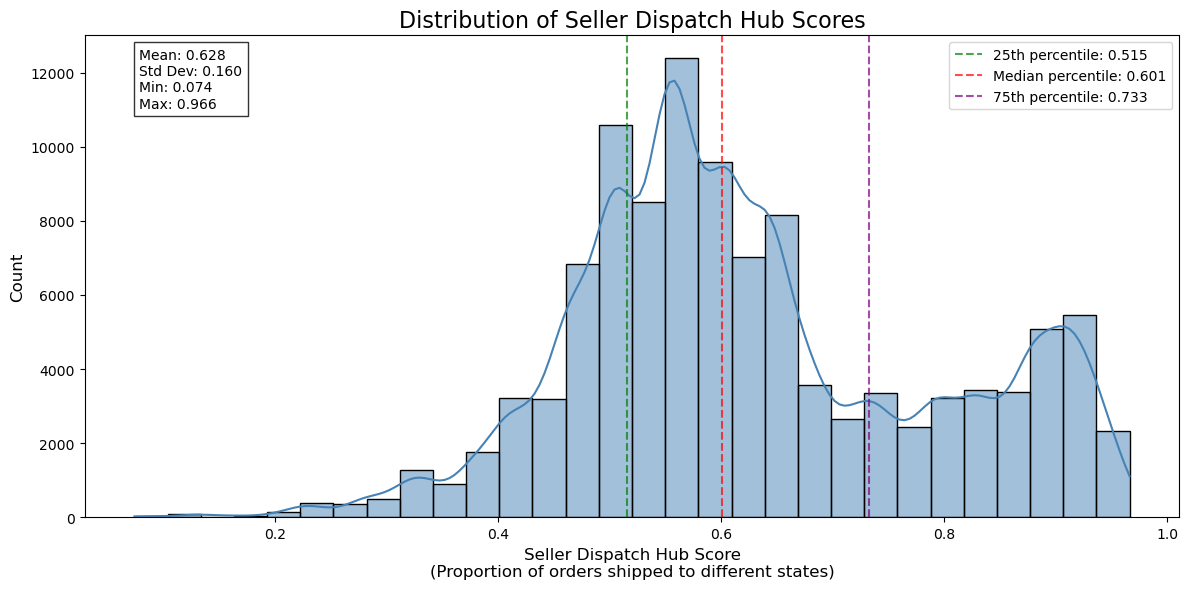

Seller Type Statistics:
             num_orders  num_sellers  avg_distance_km  late_rate
seller_type                                                     
Local             27281          982       417.436065   8.331806
Mixed-Local       27534          723       552.775719   8.494952
Mixed-Hub         27644          620       636.988646   8.327304
Hub               27474          640       778.472218   6.529810


In [30]:
# Create a histogram to visualize the distribution of seller_dispatch_hub scores
plt.figure(figsize=(12, 6))

# Main histogram
ax = sns.histplot(
    data=master_olist_ml_df, 
    x='seller_dispatch_hub', 
    bins=30, 
    kde=True, 
    color='steelblue'
)

# Add vertical lines for quartiles
quartiles = master_olist_ml_df['seller_dispatch_hub'].quantile([0.25, 0.5, 0.75])
for q, label, color in zip(quartiles, ['25th', 'Median', '75th'], ['green', 'red', 'purple']):
    plt.axvline(q, color=color, linestyle='--', alpha=0.7, 
                label=f'{label} percentile: {q:.3f}')

# Add title and labels
plt.title('Distribution of Seller Dispatch Hub Scores', fontsize=16)
plt.xlabel('Seller Dispatch Hub Score\n(Proportion of orders shipped to different states)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()

# Add some summary stats as text
mean_val = master_olist_ml_df['seller_dispatch_hub'].mean()
plt.text(0.05, 0.85, 
         f"Mean: {mean_val:.3f}\n"
         f"Std Dev: {master_olist_ml_df['seller_dispatch_hub'].std():.3f}\n"
         f"Min: {master_olist_ml_df['seller_dispatch_hub'].min():.3f}\n"
         f"Max: {master_olist_ml_df['seller_dispatch_hub'].max():.3f}", 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Show a table of statistics by seller type
seller_type_stats = (
    master_olist_ml_df
    .assign(seller_type=lambda df: pd.cut(
        df['seller_dispatch_hub'],
        bins=[0, 0.515, 0.601, 0.733, 1.01],
        labels=['Local', 'Mixed-Local', 'Mixed-Hub', 'Hub'],
    ))
    .groupby('seller_type')
    .agg(
        num_orders=('order_id', 'count'),
        num_sellers=('seller_id', 'nunique'),
        avg_distance_km=('distance_km', 'mean'),
        late_rate=('is_late', lambda x: x.mean() * 100)
    )
)

# Display the statistics
print("Seller Type Statistics:")
print(seller_type_stats)

   seller_type  count  late_rate
0        Local   5192   0.113444
1  Mixed-Local   6732   0.112597
2    Mixed-Hub   7924   0.101212
3          Hub  10723   0.085424


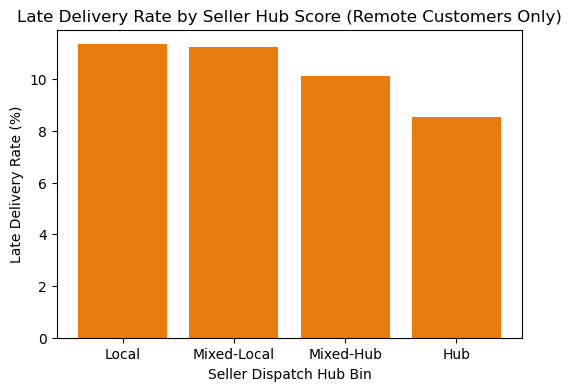

In [31]:
# Filter to only remote customer orders
remote_orders = master_olist_ml_df[master_olist_ml_df['customer_is_remote'] == 1]

# Group by hub bin, calculate late rate
remote_late_by_bin = (
    remote_orders
    .assign(seller_type=lambda df: pd.cut(
        df['seller_dispatch_hub'],
        bins=[0, 0.515, 0.601, 0.733, 1.01],
        labels=['Local', 'Mixed-Local', 'Mixed-Hub', 'Hub'],
    )).groupby('seller_type')['is_late']
    .agg(['count', 'mean'])
    .rename(columns={'mean': 'late_rate'})
    .reset_index()
)

# Display results
print(remote_late_by_bin)

# Plot (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(remote_late_by_bin['seller_type'], remote_late_by_bin['late_rate']*100, color='#E87D0D')
plt.ylabel('Late Delivery Rate (%)')
plt.xlabel('Seller Dispatch Hub Bin')
plt.title('Late Delivery Rate by Seller Hub Score (Remote Customers Only)')
plt.show()

In [32]:
# (Spearman is best for monotonic but not strictly linear relationships)
corr, _ = spearmanr(master_olist_ml_df['seller_dispatch_hub'], master_olist_ml_df['is_late'])
print(f"Spearman correlation between seller_dispatch_hub and is_late: {corr:.3f}")

Spearman correlation between seller_dispatch_hub and is_late: -0.022

In [33]:

# # 3. product_volume_cm3
# dims = ["product_length_cm", "product_height_cm", "product_width_cm"]
# df["product_volume_cm3"] = df[dims].prod(axis=1)

# # 4. density_g_per_cm3
# df["density_g_per_cm3"] = df["product_weight_g"] / df["product_volume_cm3"].clip(lower=1)

# # 5. oversize_flag, overweight_flag (90th percentile in train only if possible)
# vol_cut = df["product_volume_cm3"].quantile(0.90)
# wgt_cut = df["product_weight_g"].quantile(0.90)
# df["oversize_flag"] = (df["product_volume_cm3"] > vol_cut).astype(int)
# df["overweight_flag"] = (df["product_weight_g"] > wgt_cut).astype(int)


## Order & Actor History

### Seller 30 and 90's days rolling late delivery and order account 


In [34]:
def cycled_features_smoothed(df, days, target_col, prior=1):
    raw_rates = pd.Series(index=df.index, dtype=float)
    smoothed_rates = pd.Series(index=df.index, dtype=float)
    counts = pd.Series(index=df.index, dtype=float)
    for seller_id, s_group in df.groupby('seller_id'):
        s_group = s_group.sort_values('order_approved_at')
        r_list, s_list, c_list = [], [], []
        for idx, row in s_group.iterrows():
            end_date = row['order_approved_at']
            start_date = end_date - pd.Timedelta(days=days)
            window = s_group[(s_group['order_approved_at'] >= start_date) & (s_group['order_approved_at'] <= end_date)]
            total = len(window)
            late = window[target_col].sum()
            # Raw rate
            raw = late / total if total > 0 else 0
            # Smoothed rate (Laplace)
            smoothed = (late + prior) / (total + 2 * prior) if total > 0 else 0
            r_list.append(raw)
            s_list.append(smoothed)
            c_list.append(total)
        raw_rates.loc[s_group.index] = r_list
        smoothed_rates.loc[s_group.index] = s_list
        counts.loc[s_group.index] = c_list
    return raw_rates, smoothed_rates, counts

# Calculate lifetime dispatch late rate per seller
lifetime_rates = (
    master_olist_ml_df.groupby('seller_id')
    .agg(
        late_count=('is_late_dispatch', 'sum'),
        total_count=('is_late_dispatch', 'count')
    )
)
# Apply Laplace smoothing (prior=1)
lifetime_rates['seller_lifetime_dispatch_late_rate_smoothed'] = (lifetime_rates['late_count'] + 1) / (lifetime_rates['total_count'] + 2)
lifetime_rates['seller_lifetime_dispatch_late_rate_raw'] = lifetime_rates['late_count'] / lifetime_rates['total_count']

# Merge back to main dataframe
master_olist_ml_df = master_olist_ml_df.merge(
    lifetime_rates[['seller_lifetime_dispatch_late_rate_smoothed', 'seller_lifetime_dispatch_late_rate_raw']], 
    on='seller_id', 
    how='left'
)

# Calculate features for 30 days
master_olist_ml_df['seller_30d_dispatch_late_rate_raw'], \
master_olist_ml_df['seller_30d_dispatch_late_rate_smoothed'], \
master_olist_ml_df['seller_30d_order_count'] = cycled_features_smoothed(master_olist_ml_df, 30, 'is_late_dispatch')

# Calculate features for 90 days
master_olist_ml_df['seller_90d_dispatch_late_rate_raw'], \
master_olist_ml_df['seller_90d_dispatch_late_rate_smoothed'], \
master_olist_ml_df['seller_90d_order_count'] = cycled_features_smoothed(master_olist_ml_df, 90, 'is_late_dispatch')

In [35]:
master_olist_ml_df.shape

(109933, 53)

In [36]:
master_olist_ml_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,is_outside_home,seller_dispatch_hub,seller_lifetime_dispatch_late_rate_smoothed,seller_lifetime_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_smoothed,seller_30d_order_count,seller_90d_dispatch_late_rate_raw,seller_90d_dispatch_late_rate_smoothed,seller_90d_order_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,0,0.368421,0.018182,0.000000,0.000000,0.100000,8.0,0.000000,0.022727,42.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,...,1,0.596899,0.015748,0.008000,0.000000,0.029412,32.0,0.000000,0.016667,58.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,...,1,0.605035,0.023478,0.022648,0.034884,0.045455,86.0,0.033755,0.037657,237.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,...,1,0.836478,0.006369,0.000000,0.000000,0.100000,8.0,0.000000,0.033333,28.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,...,0,0.480000,0.011561,0.005848,0.000000,0.083333,10.0,0.000000,0.025000,38.0


### Seller's lifetime orders

In [37]:
master_olist_ml_df['seller_lifetime_order_count'] = master_olist_ml_df.groupby('seller_id')['order_id'].transform('count')

In [38]:
master_olist_ml_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,seller_dispatch_hub,seller_lifetime_dispatch_late_rate_smoothed,seller_lifetime_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_smoothed,seller_30d_order_count,seller_90d_dispatch_late_rate_raw,seller_90d_dispatch_late_rate_smoothed,seller_90d_order_count,seller_lifetime_order_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,0.368421,0.018182,0.000000,0.000000,0.100000,8.0,0.000000,0.022727,42.0,53
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,...,0.596899,0.015748,0.008000,0.000000,0.029412,32.0,0.000000,0.016667,58.0,125
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,...,0.605035,0.023478,0.022648,0.034884,0.045455,86.0,0.033755,0.037657,237.0,1148
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,...,0.836478,0.006369,0.000000,0.000000,0.100000,8.0,0.000000,0.033333,28.0,155
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,...,0.480000,0.011561,0.005848,0.000000,0.083333,10.0,0.000000,0.025000,38.0,171


### Sum of freight value per order

In [39]:
sum_freight_value = (
    master_olist_ml_df.groupby('order_id')['freight_value']
    .sum()
    .reset_index(name='sum_freight_value')
)
master_olist_ml_df = master_olist_ml_df.merge(sum_freight_value, on='order_id', how='left')

In [40]:
master_olist_ml_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,seller_lifetime_dispatch_late_rate_smoothed,seller_lifetime_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_smoothed,seller_30d_order_count,seller_90d_dispatch_late_rate_raw,seller_90d_dispatch_late_rate_smoothed,seller_90d_order_count,seller_lifetime_order_count,sum_freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,0.018182,0.000000,0.000000,0.100000,8.0,0.000000,0.022727,42.0,53,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,...,0.015748,0.008000,0.000000,0.029412,32.0,0.000000,0.016667,58.0,125,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,...,0.023478,0.022648,0.034884,0.045455,86.0,0.033755,0.037657,237.0,1148,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,...,0.006369,0.000000,0.000000,0.100000,8.0,0.000000,0.033333,28.0,155,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,...,0.011561,0.005848,0.000000,0.083333,10.0,0.000000,0.025000,38.0,171,8.72


### Quick statistical association check between new features and is_late

In [41]:
n_order_small = master_olist_ml_df.groupby('seller_id')[['seller_30d_order_count','seller_90d_order_count']].count().reset_index()
n_order_small

,seller_id,seller_30d_order_count,seller_90d_order_count
0,0015a82c2db000af6aaaf3ae2ecb0532,3,3
1,001cca7ae9ae17fb1caed9dfb1094831,234,234
2,002100f778ceb8431b7a1020ff7ab48f,54,54
3,003554e2dce176b5555353e4f3555ac8,1,1
4,004c9cd9d87a3c30c522c48c4fc07416,168,168
...,...,...,...
2960,ffc470761de7d0232558ba5e786e57b7,30,30
2961,ffdd9f82b9a447f6f8d4b91554cc7dd3,20,20
2962,ffeee66ac5d5a62fe688b9d26f83f534,14,14
2963,fffd5413c0700ac820c7069d66d98c89,58,58


In [44]:

numerical_features = [
    'seller_30d_dispatch_late_rate_raw',
    'seller_30d_dispatch_late_rate_smoothed',
    'seller_90d_dispatch_late_rate_raw',
    'seller_90d_dispatch_late_rate_smoothed',
    'seller_30d_order_count',
    'seller_90d_order_count',
    'seller_lifetime_dispatch_late_rate_smoothed', 
    'seller_lifetime_dispatch_late_rate_raw', 
    'seller_lifetime_order_count',
    'sum_freight_value'
]

# Pearson correlation
correlations = master_olist_ml_df[numerical_features + ['is_late']].corr()['is_late'].sort_values(ascending=False)
print("Pearson correlations with is_late:\n", correlations)

# Spearman (for non-normal data)
spearman_corr = master_olist_ml_df[numerical_features + ['is_late']].corr(method='spearman')['is_late'].sort_values(ascending=False)
print("Spearman correlations with is_late:\n", spearman_corr)



Pearson correlations with is_late:
 is_late                                        1.000000
seller_30d_dispatch_late_rate_raw              0.143861
seller_90d_dispatch_late_rate_raw              0.120861
seller_lifetime_dispatch_late_rate_raw         0.101570
seller_30d_dispatch_late_rate_smoothed         0.089479
seller_lifetime_dispatch_late_rate_smoothed    0.087121
seller_90d_dispatch_late_rate_smoothed         0.082270
seller_30d_order_count                         0.035468
seller_90d_order_count                         0.026133
sum_freight_value                              0.010423
seller_lifetime_order_count                    0.007461
Name: is_late, dtype: float64
Spearman correlations with is_late:
 is_late                                        1.000000
seller_30d_dispatch_late_rate_raw              0.118597
seller_90d_dispatch_late_rate_raw              0.098891
seller_lifetime_dispatch_late_rate_raw         0.069732
seller_lifetime_dispatch_late_rate_smoothed    0.053125
s

Seller lifetime order count has a very low correlation, so we'll remove it

In [45]:
# Remove seller_lifetime_order_count from numerical_features as it has a very low correlation with is_late
numerical_features = [
    'seller_30d_dispatch_late_rate_raw',
    'seller_30d_dispatch_late_rate_smoothed',
    'seller_90d_dispatch_late_rate_raw',
    'seller_90d_dispatch_late_rate_smoothed',
    'seller_30d_order_count',
    'seller_90d_order_count',
    'seller_lifetime_dispatch_late_rate_smoothed', 
    'seller_lifetime_dispatch_late_rate_raw',
    'sum_freight_value'
]

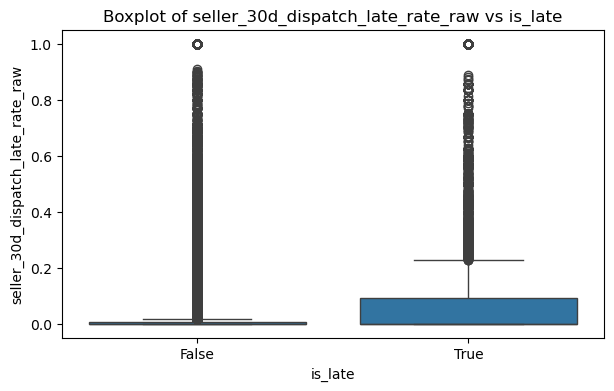

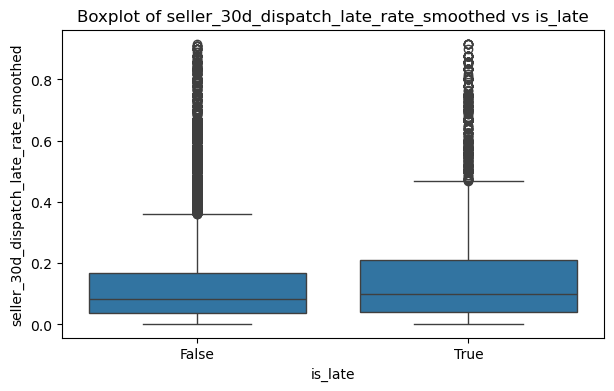

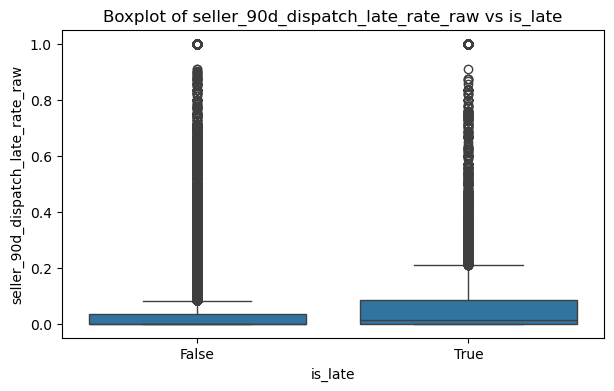

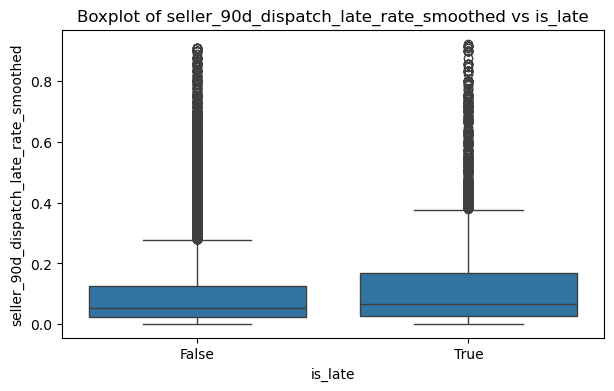

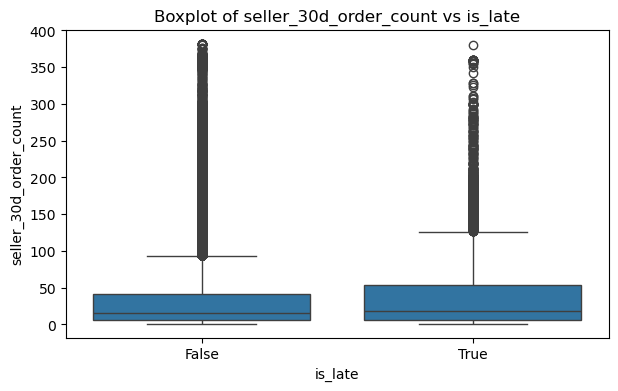

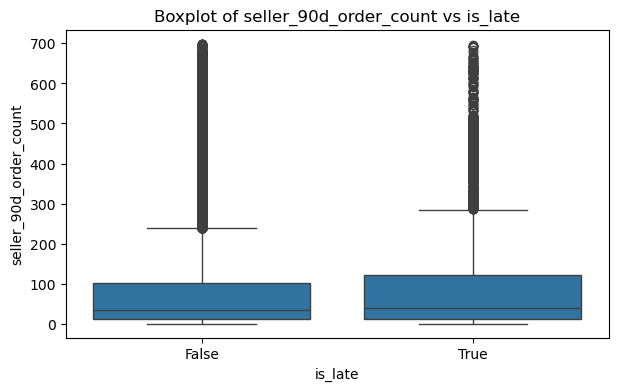

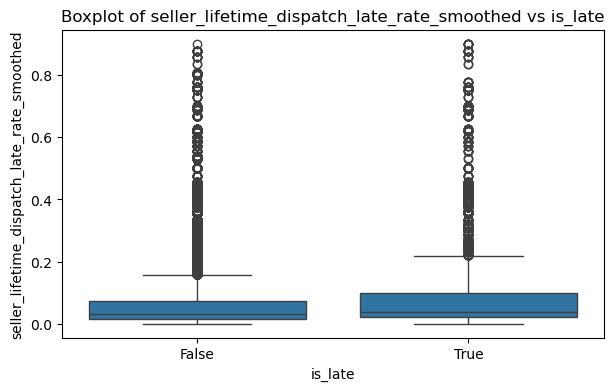

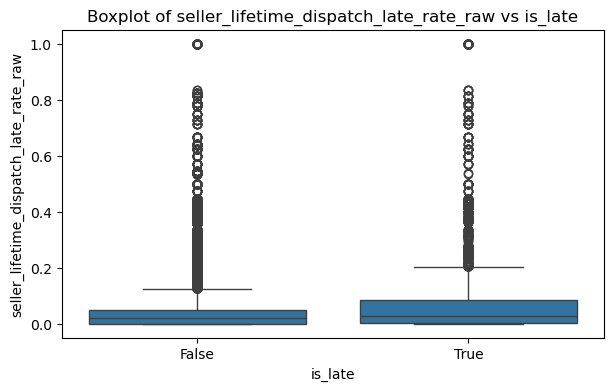

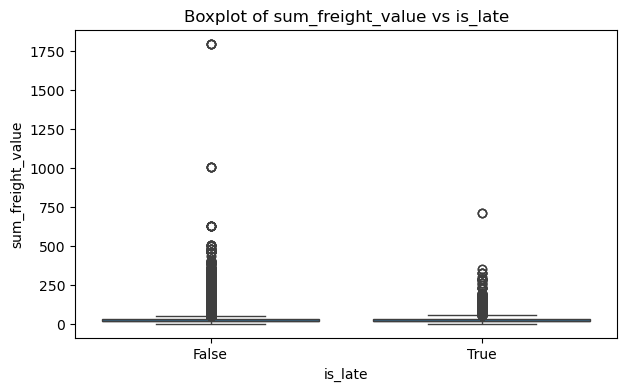

In [46]:
# boxplots before handling outliers
for col in numerical_features:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='is_late', y=col, data=master_olist_ml_df)
    plt.title(f'Boxplot of {col} vs is_late')
    plt.show()

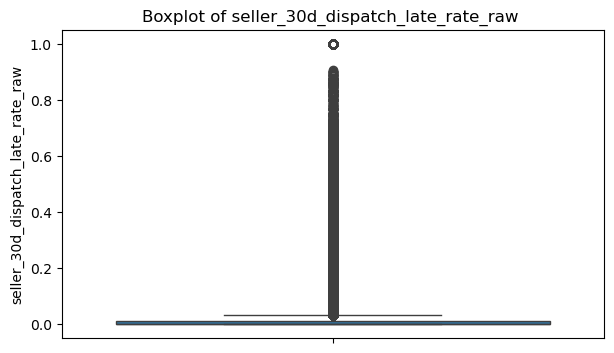

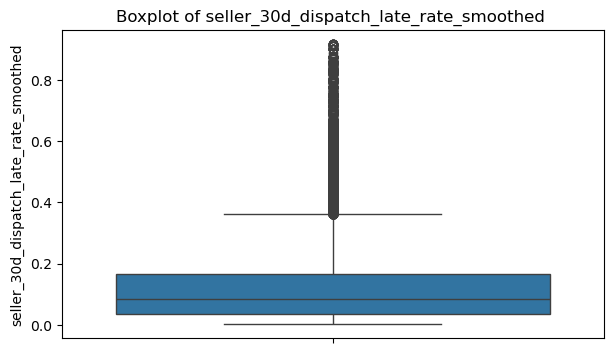

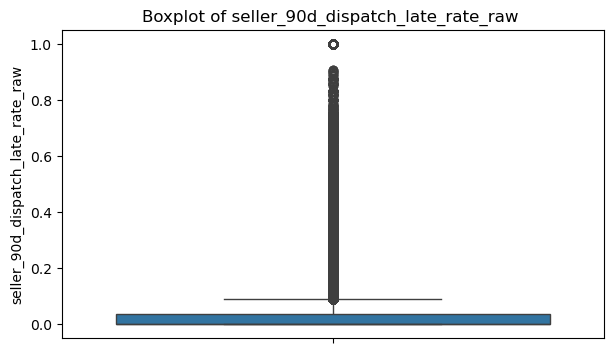

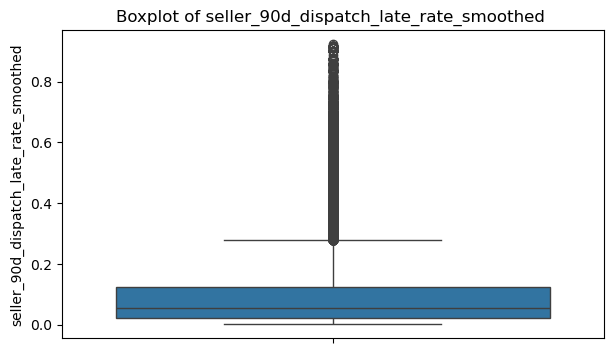

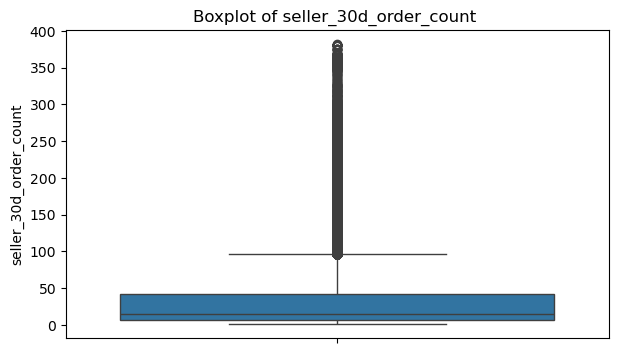

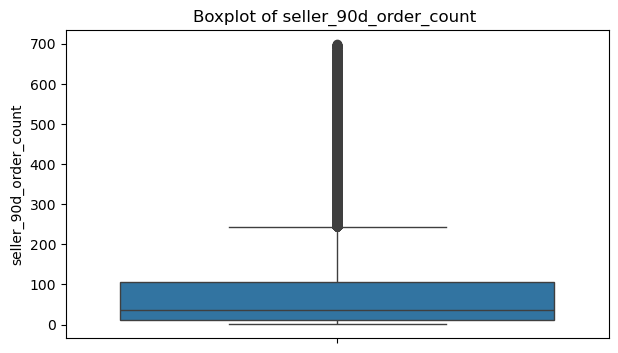

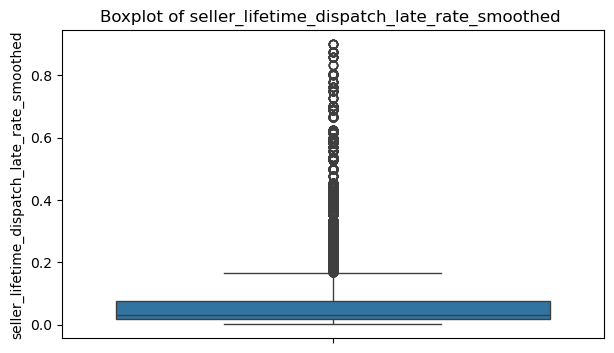

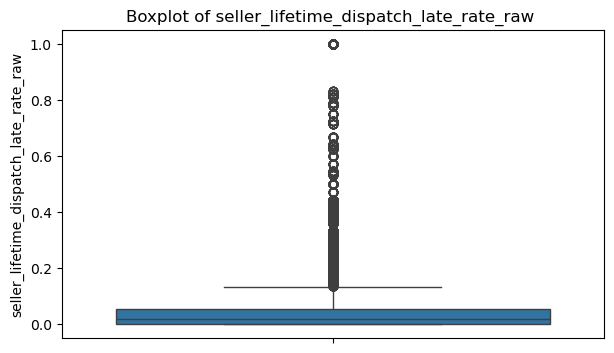

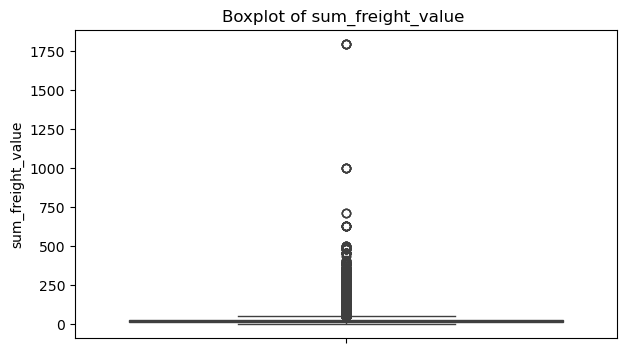

In [47]:
for col in numerical_features:
    plt.figure(figsize=(7, 4))
    sns.boxplot(y=col, data=master_olist_ml_df)
    plt.title(f'Boxplot of {col} ')
    plt.show()

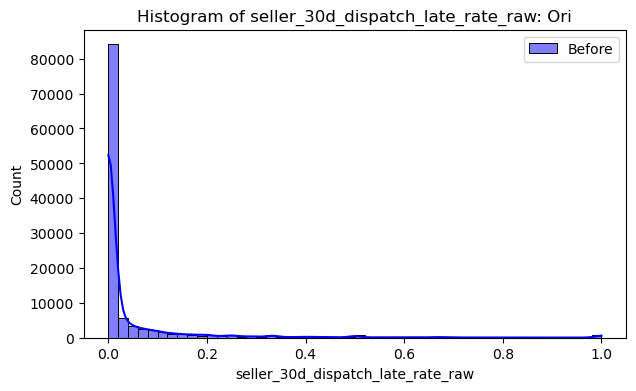

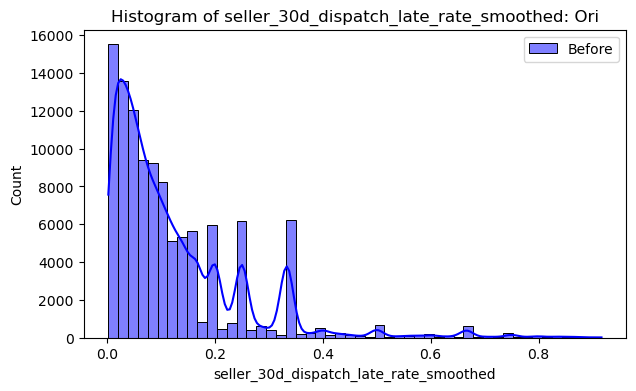

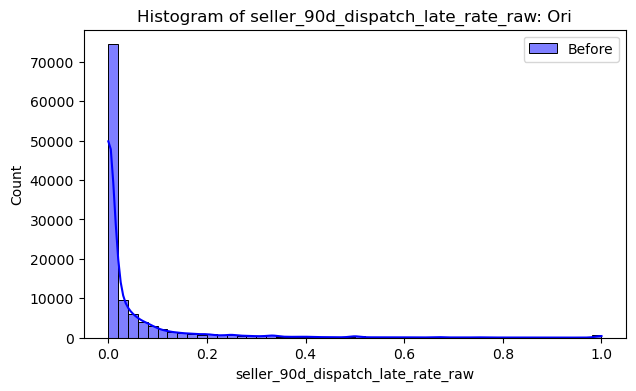

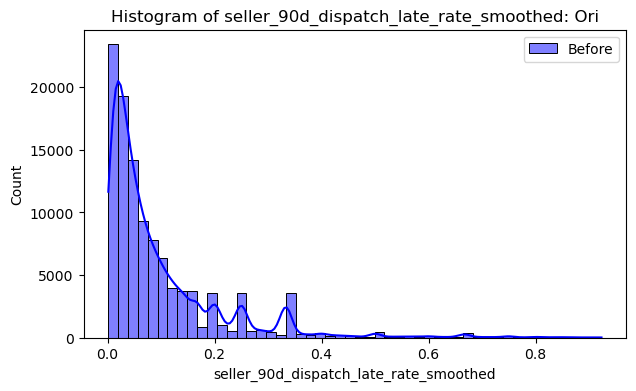

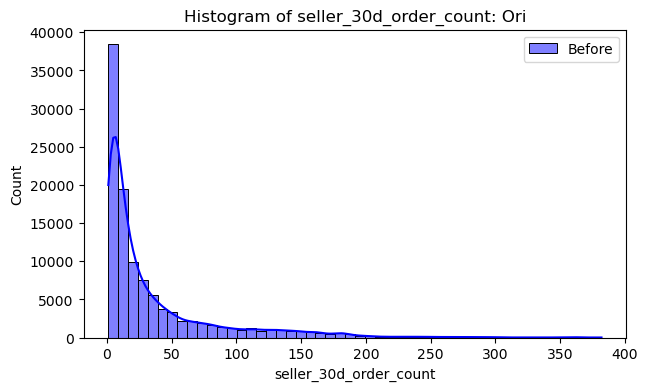

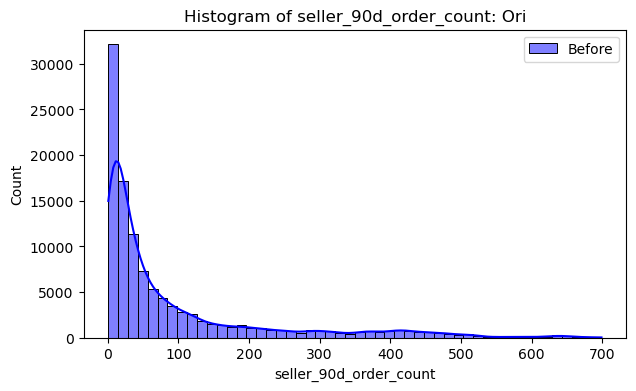

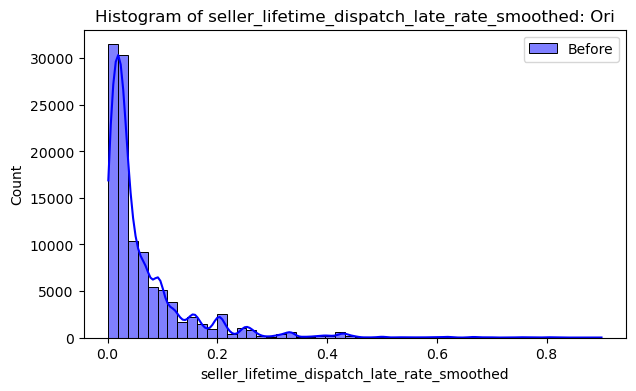

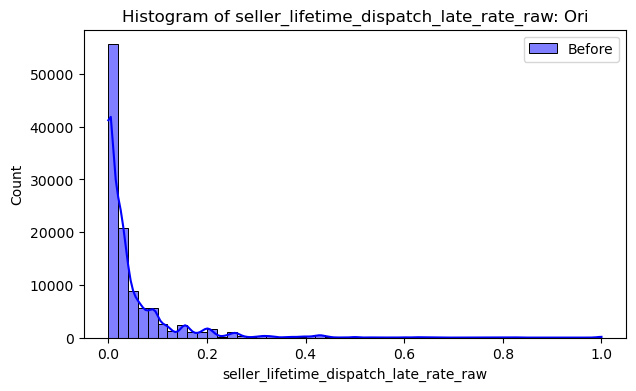

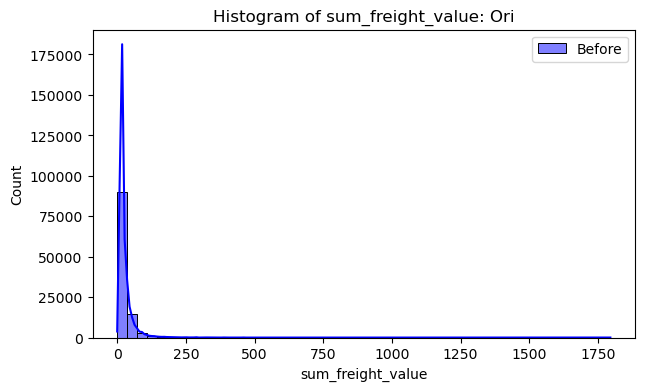

In [48]:
for col in numerical_features:
    plt.figure(figsize=(7, 4))
    sns.histplot(master_olist_ml_df[col], bins=50, kde=True, color='blue', label='Before', alpha=0.5)
    plt.legend()
    plt.title(f'Histogram of {col}: Ori')
    plt.show()

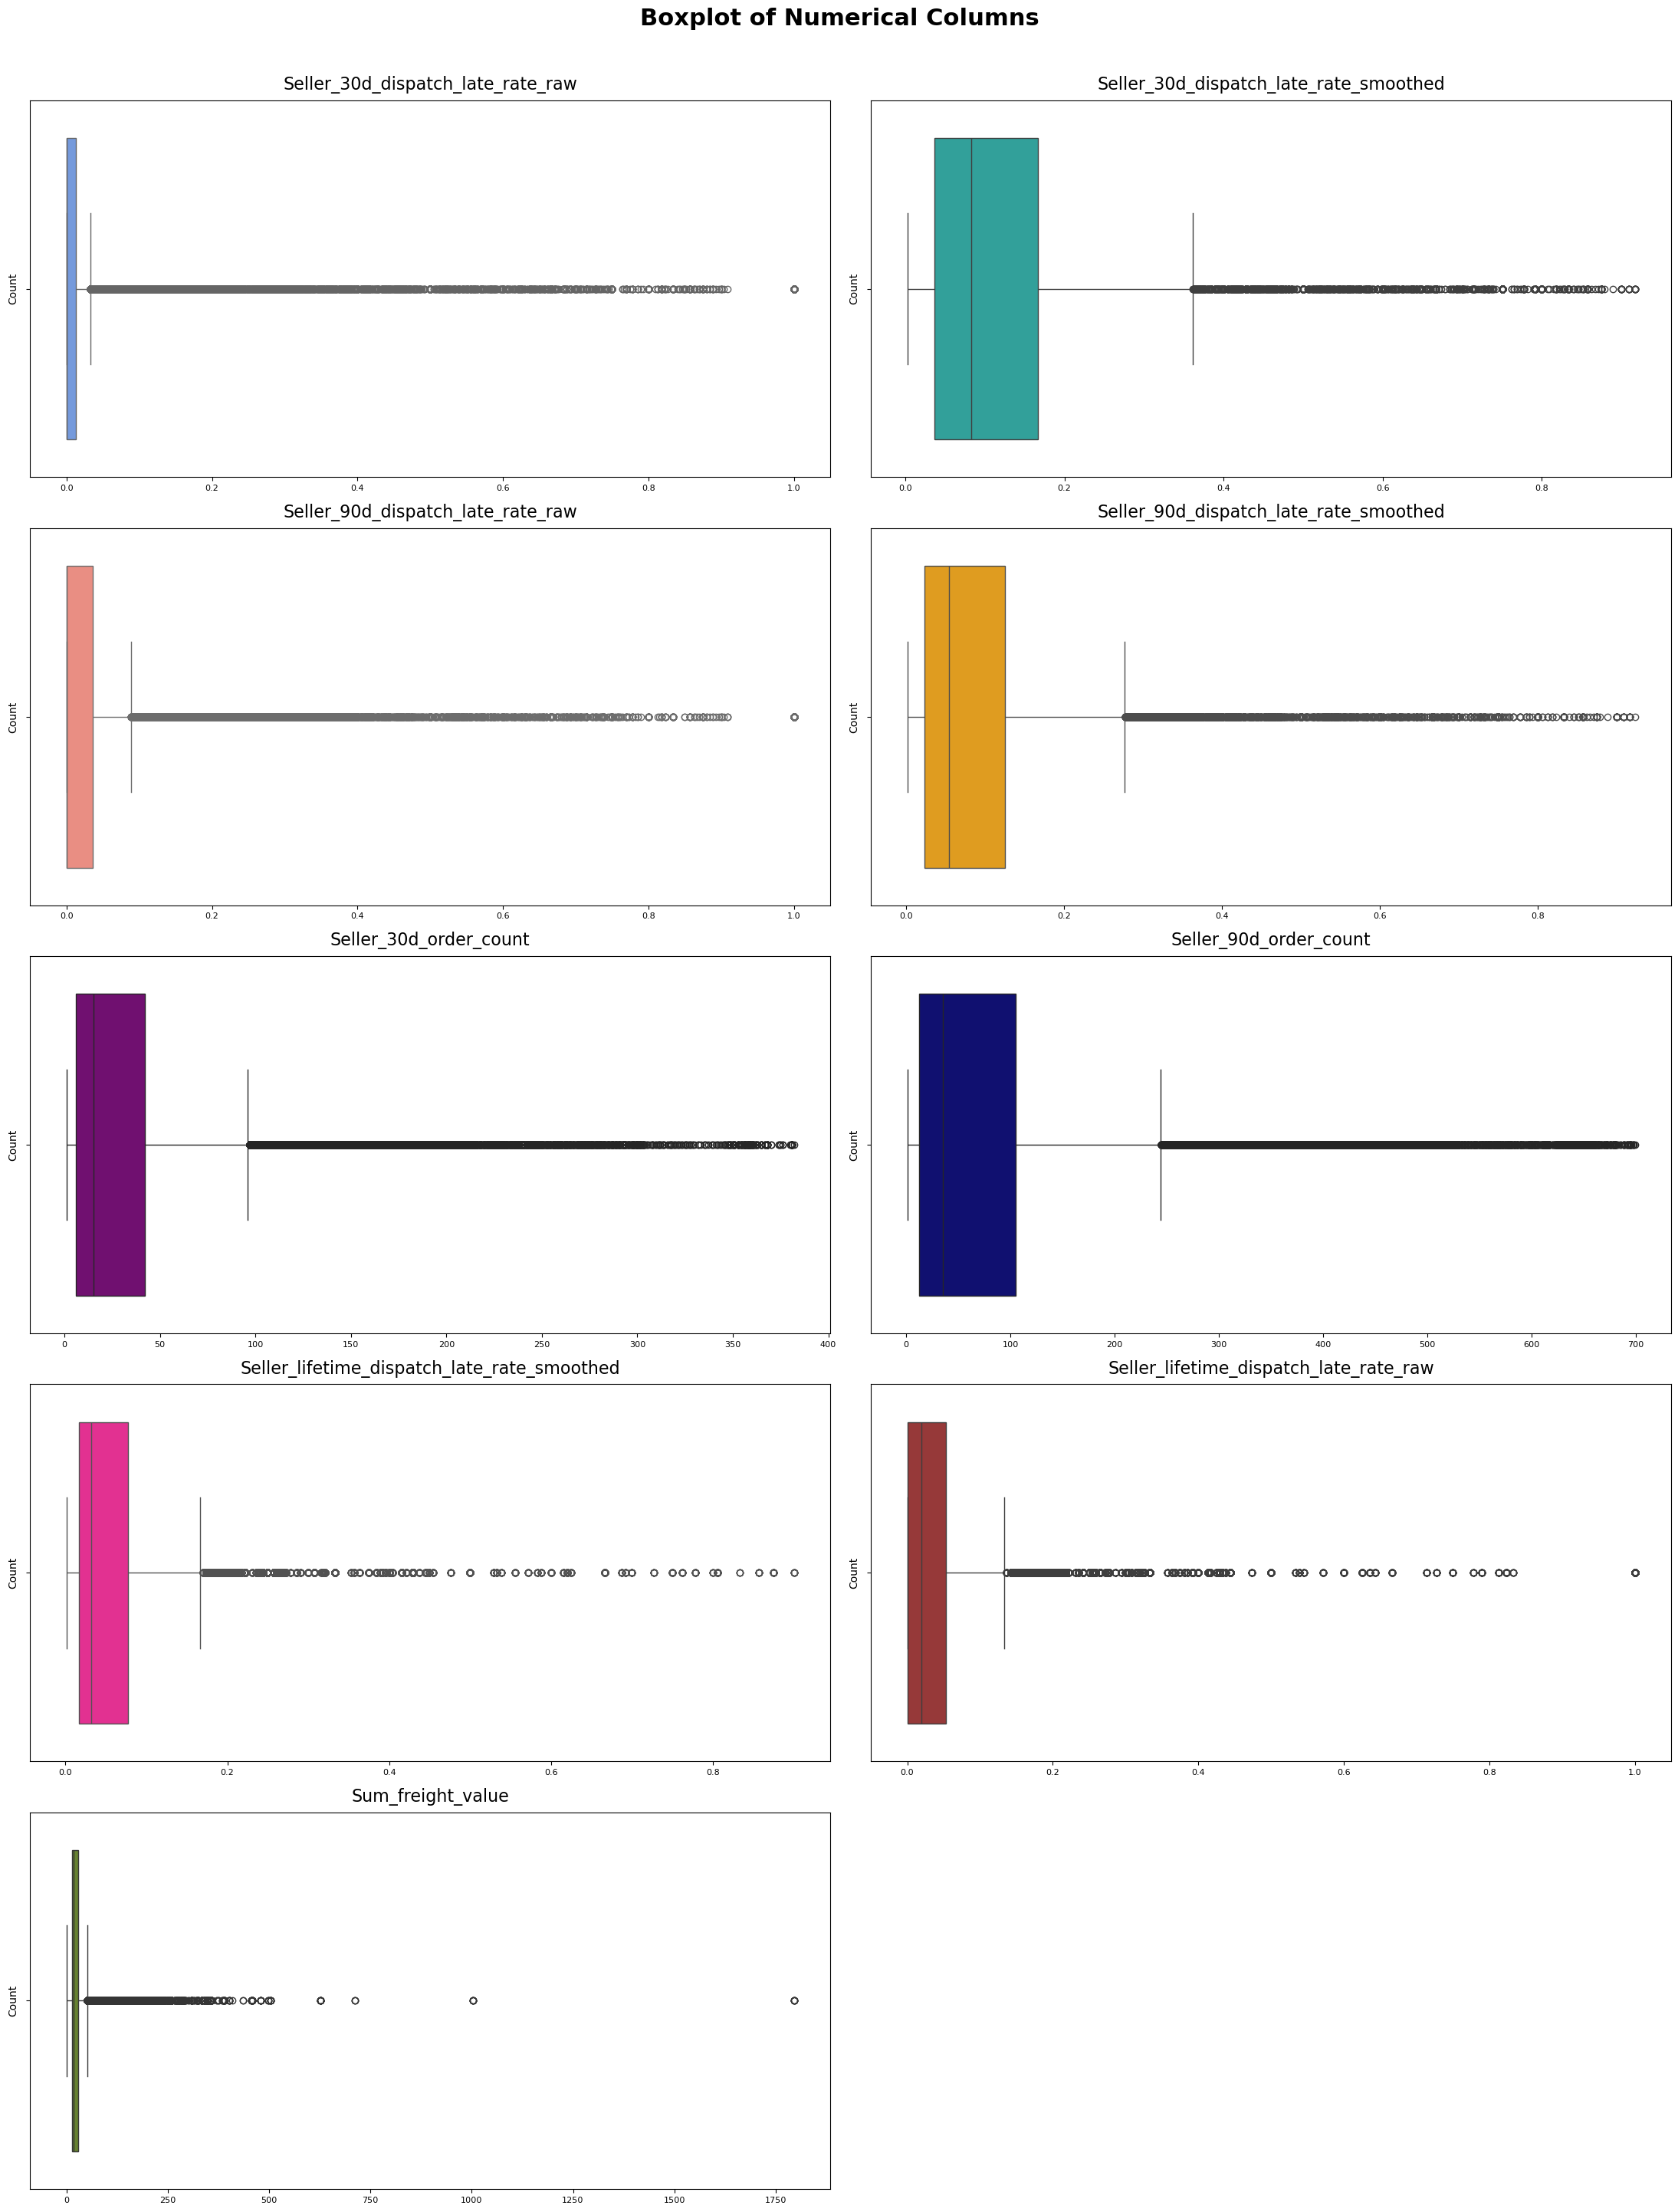

In [49]:
# Calculate the number of rows and columns needed for the plots
n_plots = len(numerical_features)
n_rows = int(np.ceil(n_plots / 2)) #2columns

# Create the subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(22, 6 * n_rows))
axes = axes.flatten()

# Colors chosen for the histogram
colors = ['cornflowerblue', 'lightseagreen', 'salmon', 'orange','purple', 'navy', 'deeppink', 'brown','olivedrab']

# Plot histograms for each numeric column with different colors
for i, column in enumerate(numerical_features):
    color_index = i % len(colors)  
    sns.boxplot(data=master_olist_ml_df, x=column, ax=axes[i], color=colors[color_index])
    axes[i].set_title(column.capitalize(), fontsize=16, pad=10)  
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Count') 
    axes[i].tick_params(axis='both', labelsize=8)  

for k in range(n_plots, n_rows *2):
    fig.delaxes(axes[k])

plt.suptitle('Boxplot of Numerical Columns', fontsize=22, fontweight='bold')

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

### Quick statistical outliers check

In [50]:
df_pre = master_olist_ml_df.copy()

In [51]:
df_pre[numerical_features].describe()

,seller_30d_dispatch_late_rate_raw,seller_30d_dispatch_late_rate_smoothed,seller_90d_dispatch_late_rate_raw,seller_90d_dispatch_late_rate_smoothed,seller_30d_order_count,seller_90d_order_count,seller_lifetime_dispatch_late_rate_smoothed,seller_lifetime_dispatch_late_rate_raw,sum_freight_value
count,109933.000000,109933.000000,109933.000000,109933.000000,109933.000000,109933.00000,109933.000000,109933.000000,109933.000000
mean,0.042141,0.123733,0.044501,0.095948,35.309880,90.02809,0.063579,0.046547,27.248761
std,0.129461,0.124669,0.115396,0.114392,49.067543,127.36208,0.084790,0.084815,33.270072
min,0.000000,0.002604,0.000000,0.001502,1.000000,1.00000,0.001333,0.000000,0.000000
25%,0.000000,0.037037,0.000000,0.023158,6.000000,12.00000,0.016484,0.000000,14.290000
50%,0.000000,0.083333,0.000000,0.054054,15.000000,35.00000,0.032258,0.019900,18.160000
75%,0.012987,0.166667,0.035714,0.125000,42.000000,105.00000,0.076923,0.053571,29.170000
max,1.000000,0.916667,1.000000,0.923077,382.000000,699.00000,0.900000,1.000000,1794.960000


No impossible values found

In [52]:
# checking the outliers number 
# Columns to analyze
result_outliers = []

for col in numerical_features:
    data = master_olist_ml_df[col]
    Q1 = np.percentile(data, 25)
    Q2 = np.percentile(data, 50)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    outliers = data[(data < lower_fence) | (data > upper_fence)]

    result_outliers.append({
        "Column": col,
        "Q1": Q1,
        "Q2": Q2,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Fence": lower_fence,
        "Upper Fence": upper_fence,
        "Outlier Count": len(outliers),
        "Lowest Outlier": outliers.min() if not outliers.empty else None,
        "Highest Outlier": outliers.max() if not outliers.empty else None
    })

summary_dfpre = pd.DataFrame(result_outliers)
summary_dfpre

,Column,Q1,Q2,Q3,IQR,Lower Fence,Upper Fence,Outlier Count,Lowest Outlier,Highest Outlier
0,seller_30d_dispatch_late_rate_raw,0.000000,0.000000,0.012987,0.012987,-0.019481,0.032468,21756,0.032520,1.000000
1,seller_30d_dispatch_late_rate_smoothed,0.037037,0.083333,0.166667,0.129630,-0.157407,0.361111,3936,0.361111,0.916667
2,seller_90d_dispatch_late_rate_raw,0.000000,0.000000,0.035714,0.035714,-0.053571,0.089286,14410,0.089286,1.000000
3,seller_90d_dispatch_late_rate_smoothed,0.023158,0.054054,0.125000,0.101842,-0.129605,0.277763,8089,0.277778,0.923077
4,seller_30d_order_count,6.000000,15.000000,42.000000,36.000000,-48.000000,96.000000,12036,97.000000,382.000000
5,seller_90d_order_count,12.000000,35.000000,105.000000,93.000000,-127.500000,244.500000,13079,245.000000,699.000000
6,seller_lifetime_dispatch_late_rate_smoothed,0.016484,0.032258,0.076923,0.060440,-0.074176,0.167582,9250,0.169811,0.900000
7,seller_lifetime_dispatch_late_rate_raw,0.000000,0.019900,0.053571,0.053571,-0.080357,0.133929,9814,0.136364,1.000000
8,sum_freight_value,14.290000,18.160000,29.170000,14.880000,-8.030000,51.490000,10470,51.500000,1794.960000


In [53]:
# handling outliers of total rooms
df_pre[df_pre['sum_freight_value'] > 1700].count()['sum_freight_value']

6

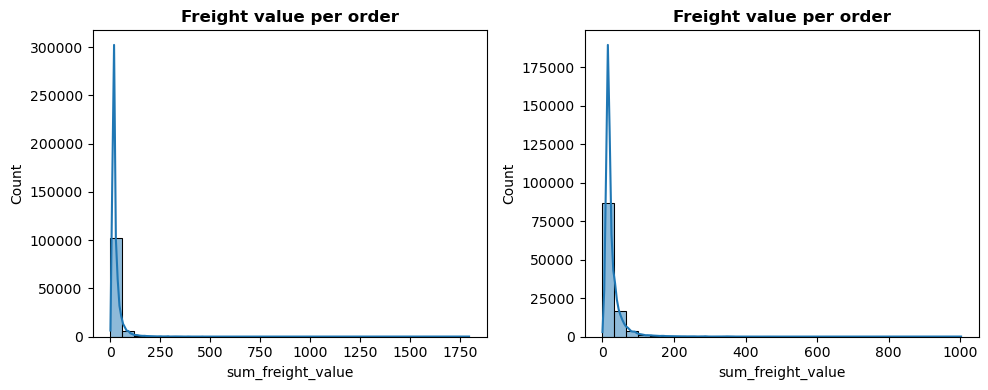

In [54]:
# Freight value per order data filtered
df_pre = df_pre[(df_pre['sum_freight_value'] <= 1700)]

# Distribution before and after filtering
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Before filtering
sns.histplot(master_olist_ml_df['sum_freight_value'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Freight value per order', fontdict={'fontsize': 12, 'fontweight': 'bold'})

# After filtering
sns.histplot(df_pre['sum_freight_value'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Freight value per order', fontdict={'fontsize': 12, 'fontweight': 'bold'})

plt.tight_layout()
plt.show()

## Temporal Features

In [55]:
from workalendar.america import Brazil                      # for Brazilian holidays (e.g., to check if a date is a holiday)

In [56]:
# SLA-related features (measuring time differences between order lifecycle events):
# Time taken (in hours) from customer purchase to order approval (seller speed)
master_olist_ml_df['purchase_to_approve_hrs'] = (
    (master_olist_ml_df['order_approved_at'] - master_olist_ml_df['order_purchase_timestamp']).dt.total_seconds() / 3600
)

# Carrier SLA window: approval to estimated delivery (in days)
master_olist_ml_df['approve_to_estimated_days'] = (
    (master_olist_ml_df['order_estimated_delivery_date'] - master_olist_ml_df['order_approved_at']).dt.days
)

# Approval to shipping deadline (seller's max allowed processing time, in days)
master_olist_ml_df['approve_to_shipping_limit_days'] = (
    (master_olist_ml_df['shipping_limit_date'] - master_olist_ml_df['order_approved_at']).dt.days
)

In [57]:
# Temporal purchase patterns (extract useful purchase time features):
# Hour of the day when the purchase occurred (0–23):
master_olist_ml_df['purchase_hour'] = master_olist_ml_df['order_purchase_timestamp'].dt.hour

# Day of the week of purchase (0=Monday, 6=Sunday):
master_olist_ml_df['purchase_dow'] = master_olist_ml_df['order_purchase_timestamp'].dt.dayofweek

# Month when the order was placed (1–12):
master_olist_ml_df['purchase_month'] = master_olist_ml_df['order_purchase_timestamp'].dt.month

# Boolean flag (true if the purchase was on a weekend (Saturday or Sunday)):
master_olist_ml_df['is_weekend'] = master_olist_ml_df['purchase_dow'].isin([5, 6]).astype(int)

In [58]:
cal = Brazil()

# --- Brazil holiday flag (includes Black Friday) ---
def is_brazil_holiday(date_obj):
    if cal.is_holiday(date_obj):
        return True
    # Black Friday: 4th Friday of November
    if date_obj.month == 11 and date_obj.weekday() == 4:
        if (date_obj.day - 1) // 7 == 3:  # 4th Friday
            return True
    return False

master_olist_ml_df['is_brazil_holiday'] = master_olist_ml_df['order_purchase_timestamp'].dt.date.apply(is_brazil_holiday).astype(int)

In [59]:
master_olist_ml_df[master_olist_ml_df['is_brazil_holiday'] == 1].head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,seller_lifetime_order_count,sum_freight_value,purchase_to_approve_hrs,approve_to_estimated_days,approve_to_shipping_limit_days,purchase_hour,purchase_dow,purchase_month,is_weekend,is_brazil_holiday
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-21,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,...,10,17.12,2.889167,25,5,21,4,11,0,1
64,8f06cc6465925031568537b815f1198d,9916715c2ab6ee1710c9c32f0a534ad2,delivered,2017-11-15 11:31:41,2017-11-15 11:46:42,2017-12-05,bf0303939d54b8df5da4762bbaab1955,22631,rio de janeiro,RJ,...,63,18.34,0.250278,19,6,11,2,11,0,1
103,0e782c3705510e717d28907746cbda82,3a897024068ed42a183de61d5727d866,delivered,2018-05-01 08:12:37,2018-05-01 08:52:58,2018-05-16,adeefbe14d26d3bf90facfeaae35d605,4845,sao paulo,SP,...,264,7.39,0.672500,14,6,8,1,5,0,1
141,b01875821b8dcb6abc61776f0f971bce,818596f5b68adfe2c11498ebb6d39e02,delivered,2017-11-24 21:55:22,2017-11-25 01:31:43,2017-12-15,8731e1c5aa27eced509f47d8012ff81e,20270,rio de janeiro,RJ,...,1417,78.56,3.605833,19,5,21,4,11,0,1
142,b01875821b8dcb6abc61776f0f971bce,818596f5b68adfe2c11498ebb6d39e02,delivered,2017-11-24 21:55:22,2017-11-25 01:31:43,2017-12-15,8731e1c5aa27eced509f47d8012ff81e,20270,rio de janeiro,RJ,...,1417,78.56,3.605833,19,5,21,4,11,0,1
192,1370fae9b19ee5e01a2d609eb18b7c8a,22eb8142d6313bab19fa6c657170ae6b,delivered,2017-11-15 13:47:34,2017-11-15 13:55:31,2017-12-14,66d7c05de70168738de8f6f8b5adce82,47630,serra do ramalho,BA,...,426,28.20,0.132500,28,6,13,2,11,0,1
267,c263211bd219538f7c031591e87ef0d7,ed8c52327eecff596e141636d5b556d2,delivered,2017-11-24 16:56:46,2017-11-28 03:48:24,2017-12-19,b6ebed144895adea96b6193124ea3db4,85501,pato branco,PR,...,1417,34.54,82.860556,20,7,16,4,11,0,1
268,c263211bd219538f7c031591e87ef0d7,ed8c52327eecff596e141636d5b556d2,delivered,2017-11-24 16:56:46,2017-11-28 03:48:24,2017-12-19,b6ebed144895adea96b6193124ea3db4,85501,pato branco,PR,...,1417,34.54,82.860556,20,7,16,4,11,0,1
298,fb9b2930f4a30f96c7cc98eaaa85e5f0,02ed2cff54eb047cdbe79dd0535945d4,delivered,2017-11-24 14:15:53,2017-11-24 16:19:01,2017-12-14,757921c3d0047781031e9bcbaf2c393c,5119,sao paulo,SP,...,817,13.52,2.052222,19,6,14,4,11,0,1
316,52e5445828db681d83dccb33a15ecac4,d42ee2c04270ba237933c8bdd5e1c761,delivered,2017-11-24 17:37:41,2017-11-24 20:56:27,2017-12-27,c53d90ab068a7fde8fb74003248e1ebc,44200,santo amaro,BA,...,1148,24.06,3.312778,32,6,17,4,11,0,1


In [60]:
# Show sample output:
display(master_olist_ml_df.head())

# Check for missing values:
print("\nMissing values per column:")
display(master_olist_ml_df.isnull().sum())

# Purchase hour distribution:
print("\nPurchase hour value counts:")
display(master_olist_ml_df['purchase_hour'].value_counts().sort_index())

# Brazil holiday purchases breakdown:
print("\nBrazil holiday purchases breakdown:")
display(master_olist_ml_df['is_brazil_holiday'].value_counts())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,...,seller_lifetime_order_count,sum_freight_value,purchase_to_approve_hrs,approve_to_estimated_days,approve_to_shipping_limit_days,purchase_hour,purchase_dow,purchase_month,is_weekend,is_brazil_holiday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,...,53,8.72,0.178333,15,4,10,0,10,0,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,...,125,22.76,30.713889,17,4,20,1,7,0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,...,1148,19.22,0.276111,26,5,8,2,8,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,...,155,27.20,0.298056,26,5,19,5,11,1,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,...,171,8.72,1.030556,12,5,21,1,2,0,0



Missing values per column:


order_id                    0
customer_id                 0
order_status                0
order_purchase_timestamp    0
order_approved_at           0
                           ..
purchase_hour               0
purchase_dow                0
purchase_month              0
is_weekend                  0
is_brazil_holiday           0
Length: 63, dtype: int64


Purchase hour value counts:


purchase_hour
0     2655
1     1264
2      575
3      299
4      242
5      213
6      532
7     1341
8     3334
9     5338
10    6863
11    7246
12    6646
13    7189
14    7355
15    7164
16    7462
17    6831
18    6389
19    6573
20    6724
21    6753
22    6398
23    4547
Name: count, dtype: int64


Brazil holiday purchases breakdown:


is_brazil_holiday
0    106888
1      3045
Name: count, dtype: int64

In [61]:
master_olist_ml_df.shape

(109933, 63)

In [62]:
temporal_features = ['purchase_to_approve_hrs', 'approve_to_estimated_days',
       'approve_to_shipping_limit_days', 'purchase_hour', 'purchase_dow',
       'purchase_month', 'is_weekend', 'is_brazil_holiday']

In [63]:
# Create summary of all unique values for temporal features:
summary = []

for col in temporal_features:
    unique_vals = master_olist_ml_df[col].dropna().unique()
    summary.append({
        'Column': col,
        'Unique Count': len(unique_vals),
        # Convert to list of strings to prevent truncation:
        'Unique Values': list(map(str, unique_vals))
    })

df_temporal_summary = pd.DataFrame(summary)

# Improve display settings in Jupyter/Notebook:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

df_temporal_summary

,Column,Unique Count,Unique Values
0,purchase_to_approve_hrs,32616,"[0.17833333333333334, 30.71388888888889, 0.2761111111111111, 0.2980555555555556, 1.0305555555555554, 0.21888888888888888, 0.1947222222222222, 32.36055555555556, 0.175, 0.15222222222222223, 0.19916666666666666, 41.11472222222222, 0.18444444444444444, 0.9386111111111111, 124.46388888888889, 0.13916666666666666, 0.1475, 0.17805555555555555, 0.23, 13.544166666666667, 0.2808333333333333, 0.21305555555555555, 0.20055555555555554, 15.669722222222223, 26.73138888888889, 24.5825, 1.6355555555555557, 25.156388888888888, 0.9513888888888888, 38.780833333333334, 0.9130555555555555, 47.969166666666666, 0.1922222222222222, 0.17333333333333334, 0.2633333333333333, 31.927777777777777, 29.314444444444444, 87.20055555555555, 0.26916666666666667, 0.19361111111111112, 2.8891666666666667, 0.24222222222222223, 0.16194444444444445, 0.15833333333333333, 0.2388888888888889, 8.307777777777778, 0.3338888888888889, 31.94, 36.846666666666664, 18.877777777777776, 0.25305555555555553, 0.14583333333333334, 0.24805555555555556, 0.5444444444444444, 0.22527777777777777, 0.84, 0.0, 29.905277777777776, 28.8175, 0.2461111111111111, 0.25027777777777777, 33.73777777777778, 57.619166666666665, 0.10944444444444444, 0.14222222222222222, 0.9761111111111112, 36.830555555555556, 29.964166666666667, 0.2911111111111111, 4.7625, 0.24138888888888888, 39.41138888888889, 12.002777777777778, 0.25833333333333336, 58.95805555555555, 0.2086111111111111, 30.095555555555556, 0.30916666666666665, 25.965, 0.18194444444444444, 0.22944444444444445, 0.20694444444444443, 12.87888888888889, 17.119722222222222, 24.178333333333335, 37.88666666666666, 0.4330555555555556, 0.23694444444444446, 0.6725, 9.633055555555556, 0.2836111111111111, 26.877222222222223, 44.01555555555556, 0.5325, 0.2411111111111111, 0.24305555555555555, 0.36333333333333334, 0.18416666666666667, 0.14944444444444444, 28.141944444444444, ...]"
1,approve_to_estimated_days,102,"[15, 17, 26, 12, 22, 21, 39, 24, 25, 38, 13, 19, 34, 33, 27, 8, 43, 6, 42, 46, 10, 28, 31, 7, 30, 41, 16, 23, 14, 20, 9, 37, 29, 11, 1, 18, 47, 3, 0, 32, 35, 4, 53, 49, 36, 40, 48, 5, 61, 58, 56, 2, 44, 63, 50, 45, 54, 84, 51, 72, 67, 52, 73, 59, 60, 70, 65, 55, 62, 71, 94, 57, 68, 109, 82, 144, 64, 83, 66, 86, 90, 91, 101, 85, 78, 74, 149, -1, 69, -5, 88, 92, -2, 153, 95, -6, 81, 116, 75, 139, ...]"
2,approve_to_shipping_limit_days,63,"[4, 5, 6, 2, 13, 9, 10, 7, 8, 18, 3, 1, 12, 11, 14, -1, 15, 20, 21, -2, 17, 16, 19, 23, 34, 0, 25, 24, 22, -5, 27, 41, 33, 26, 44, 45, 50, 42, 35, 28, 46, -4, 32, -6, 29, 36, -3, 38, 92, -7, 40, 43, 31, 72, 37, 49, 48, 47, 97, 39, 30, 1051, 68]"
3,purchase_hour,24,"[10, 20, 8, 19, 21, 13, 18, 11, 17, 14, 23, 0, 15, 7, 1, 12, 16, 22, 9, 3, 6, 4, 5, 2]"
4,purchase_dow,7,"[0, 1, 2, 5, 6, 3, 4]"
5,purchase_month,12,"[10, 7, 8, 11, 2, 5, 1, 6, 3, 12, 9, 4]"
6,is_weekend,2,"[0, 1]"
7,is_brazil_holiday,2,"[0, 1]"


In [64]:
temporal_features

['purchase_to_approve_hrs',
 'approve_to_estimated_days',
 'approve_to_shipping_limit_days',
 'purchase_hour',
 'purchase_dow',
 'purchase_month',
 'is_weekend',
 'is_brazil_holiday']

In [65]:
# Target variable:
target_col = 'is_late'

# Define numeric features:
temporal_numeric_features = [
    'purchase_to_approve_hrs',
    'approve_to_estimated_days',
    'approve_to_shipping_limit_days',
]

# Define categorical features (incl. binary + encoded date parts):
temporal_categorical_features = [
    'purchase_hour',
    'purchase_dow',
    'purchase_month',
    'is_weekend',
    'is_brazil_holiday'
]

In [66]:
# Point-biserial correlation for numeric features with binary target:
print("Correlation between numeric features and 'is_late':")
for col in temporal_numeric_features:
    corr, p = stats.pointbiserialr(master_olist_ml_df[col], master_olist_ml_df['is_late'])
    
    strength = ''
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        strength = 'strong'
    elif abs_corr >= 0.3:
        strength = 'moderate'
    elif abs_corr >= 0.1:
        strength = 'weak'
    else:
        strength = 'very weak or no'

    print(f"{col}: correlation = {corr:.3f}, strength = {strength} correlation (p-value = {p:.4f})")

Correlation between numeric features and 'is_late':
purchase_to_approve_hrs: correlation = 0.032, strength = very weak or no correlation (p-value = 0.0000)
approve_to_estimated_days: correlation = -0.066, strength = very weak or no correlation (p-value = 0.0000)
approve_to_shipping_limit_days: correlation = -0.013, strength = very weak or no correlation (p-value = 0.0000)


In [67]:
# Cramér’s V for categorical features with binary target:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

print("\nAssociation between categorical features and 'is_late' (Cramér’s V):")
for col in temporal_categorical_features:
    v = cramers_v(master_olist_ml_df[col], master_olist_ml_df['is_late'])
    
    strength = ''
    if v >= 0.5:
        strength = 'strong'
    elif v >= 0.3:
        strength = 'moderate'
    elif v >= 0.1:
        strength = 'weak'
    else:
        strength = 'very weak or no'

    print(f"{col}: Cramér’s V = {v:.3f}, strength = {strength} association")


Association between categorical features and 'is_late' (Cramér’s V):
purchase_hour: Cramér’s V = 0.013, strength = very weak or no association
purchase_dow: Cramér’s V = 0.018, strength = very weak or no association
purchase_month: Cramér’s V = 0.161, strength = weak association
is_weekend: Cramér’s V = 0.009, strength = very weak or no association
is_brazil_holiday: Cramér’s V = 0.023, strength = very weak or no association


**Correlation & Association Analysis for Temporal Features**

We evaluated the predictive power of our temporal and SLA features using:
- **Point-biserial correlation** (for numeric features vs. binary target `is_late`)
- **Cramér’s V** (for categorical features vs. binary target)

**Results**
All features showed **very weak to weak individual association** with late deliveries (|r| < 0.1, Cramér’s V < 0.15).  
This is typical in real-world, imbalanced e-commerce datasets and does **not** mean the features are useless.

- **Non-linear models** (like CatBoost/XGB) can leverage complex interactions between these features, even if their direct correlations are low.
- **Large sample size** means small effects are statistically significant (very low p-values), but we focus on effect size for modeling.

**Conclusion:**  
We will retain these temporal features for initial modeling and use feature importance (SHAP values) and ablation tests to decide which features are worth keeping in the final model.


# Final

In [68]:
features_to_keep = [
    # Engineered features (yours + teammate’s)
    'distance_km',
    'same_state',
    'freight_ratio',
    'customer_is_remote',
    'seller_dispatch_hub',
    'seller_30d_dispatch_late_rate_raw',
    'seller_30d_dispatch_late_rate_smoothed',
    'seller_30d_order_count',
    'seller_90d_dispatch_late_rate_raw',
    'seller_90d_dispatch_late_rate_smoothed',
    'seller_90d_order_count',
    'sum_freight_value',
    
    # Key raw features
    'price',
    'total_payment_value',
    'customer_state',
    'seller_state',
    'freight_value',
    'product_category_name_english',   # or 'product_category_name', but not both!
    'payment_types',
    
    # Target variable
    'is_late'
]

features_to_keep = temporal_features + features_to_keep 

In [69]:
final_master_olist_ml_df = master_olist_ml_df[[col for col in features_to_keep if col in master_olist_ml_df.columns]]

print("Columns in ML dataset:", final_master_olist_ml_df.columns.tolist())
print("Rows:", len(final_master_olist_ml_df))

Columns in ML dataset: ['purchase_to_approve_hrs', 'approve_to_estimated_days', 'approve_to_shipping_limit_days', 'purchase_hour', 'purchase_dow', 'purchase_month', 'is_weekend', 'is_brazil_holiday', 'distance_km', 'same_state', 'freight_ratio', 'customer_is_remote', 'seller_dispatch_hub', 'seller_30d_dispatch_late_rate_raw', 'seller_30d_dispatch_late_rate_smoothed', 'seller_30d_order_count', 'seller_90d_dispatch_late_rate_raw', 'seller_90d_dispatch_late_rate_smoothed', 'seller_90d_order_count', 'sum_freight_value', 'price', 'total_payment_value', 'customer_state', 'seller_state', 'freight_value', 'product_category_name_english', 'payment_types', 'is_late']
Rows: 109933


In [70]:
final_master_olist_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109933 entries, 0 to 109932
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   purchase_to_approve_hrs                 109933 non-null  float64
 1   approve_to_estimated_days               109933 non-null  int64  
 2   approve_to_shipping_limit_days          109933 non-null  int64  
 3   purchase_hour                           109933 non-null  int32  
 4   purchase_dow                            109933 non-null  int32  
 5   purchase_month                          109933 non-null  int32  
 6   is_weekend                              109933 non-null  int32  
 7   is_brazil_holiday                       109933 non-null  int32  
 8   distance_km                             109933 non-null  float64
 9   same_state                              109933 non-null  int32  
 10  freight_ratio                           1099

In [71]:
final_master_olist_ml_df.to_csv("../data/cleaned_data/olist_ml_ready_dataset.csv", index=False)